# Предсказание стартапов

## Формулировка задачи

В задаче представлены данные о стартапах с функционировавших в период с 1970 по 2018 годы. Необходимо предсказать, какие из них закроются.

---

## Описание данных

Данные о стартапах находятся в файлах: 
- kaggle_startups_train_28062024.csv - тренировочные данные
- kaggle_startups_test_28062024.csv - тестовые данные


Данные:
- name - Название стартапа
- category_list - Список категорий, к которым относится стартап
- funding_total_usd - Общая сумма финансирования в USD
- status - Статус стартапа (закрыт или действующий)
- country_code - Код страны
- state_code - Код штата
- region - Регион
- city - Город
- funding_rounds - Количество раундов финансирования
- founded_at - Дата основания
- first_funding_at - Дата первого раунда финансирования
- last_funding_at - Дата последнего раунда финансирования
- closed_at - Дата закрытия стартапа (если применимо)
- lifetime - Время существования стартапа в днях

---

## План работы.

- [**Открыть файлы с данными, рассмотреть общую информацию о них.**](#chapter1)
- [**Проверить данные на наличие дубликатов и пропусков, сделать необходимую предобработку данных.**](#chapter2)
- [**Построить диаграммы для всех признаков, провести исследовательский и корреляционный анализ.**](#chapter3)
- [**Используя пайплайны, обучить несколько моделей, проварьировав их параметры, узнать лучшую модель.**](#chapter4)
- [**Проанализировать важность признаков.**](#chapter5)
- [**Сделать общий вывод.**](#chapter6)

---

**Делаю необходимые для работы импорты.**

In [1]:
import os #Для указания правильных путей к файлам
import pandas as pd #Для работы с датасетами
import matplotlib.pyplot as plt #Для работы с графиками
import numpy as np #Для работы с формулами и числами
import seaborn as sns #Для построения тепловых карт и ящиков с усами
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline #Для использования пайплайнов
from sklearn.compose import ColumnTransformer #Для преобразования столбцов
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler,
    RobustScaler) #Классы для кодирования категориальных данных и масштабирования количественных данных
from sklearn.metrics import f1_score # Для работы с метрикой f1
from phik import phik_matrix
from phik.report import plot_correlation_matrix #Для построения матрицы корреляции
from datetime import datetime #Для работы с датами
from imblearn.over_sampling import ADASYN #Для оверсемплинга
from sklearn.linear_model import LogisticRegression # Логистическая регрессия
from sklearn.neighbors import KNeighborsClassifier # Метод k ближайших соседей
from sklearn.tree import DecisionTreeClassifier # Дерево решений
from sklearn.svm import SVC # Метод опорных векторов
import shap #Для оценки важности признаков

In [2]:
pd.set_option('display.max_columns', None) #Опция для отображения всех столбцов в таблицах

In [3]:
RANDOM_STATE = 42 #Фиксирую случайное состояние

## Загрузка данных <a class="anchor" id="chapter1"></a>

In [4]:
pth1_train_0 = r'datasets\kaggle_startups_train_28062024.csv' 
pth2_train_0 = '/datasets/kaggle_startups_train_28062024.csv'
if os.path.exists(pth1_train_0):
    train_0 = pd.read_csv(pth1_train_0)
elif os.path.exists(pth2_train_0):
    train_0 = pd.read_csv(pth2_train_0)
else:
    print('Something is wrong')
train_0.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN


In [5]:
pth1_test_0 = r'datasets\kaggle_startups_test_28062024.csv' 
pth2_test_0 = '/datasets/kaggle_startups_test_28062024.csv'
if os.path.exists(pth1_test_0):
    test_0 = pd.read_csv(pth1_test_0)
elif os.path.exists(pth2_test_0):
    test_0 = pd.read_csv(pth2_test_0)
else:
    print('Something is wrong')
test_0.head(10)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
5,Quickfire Games,Design|Entertainment|Games,160000.0,NaN,NaN,NaN,NaN,2,2013-09-18,2014-09-18,1583
6,Sente Inc.,Biotechnology,26842000.0,USA,CA,San Diego,Encinitas,5,2009-01-31,2014-06-02,4018
7,Triosyn,Health Care|Medical|Therapeutics,4000000.0,NaN,NaN,NaN,NaN,1,2003-06-02,2003-06-02,5576
8,Urgent.ly,Software,8710000.0,USA,VA,"Washington, D.C.",Sterling,3,2014-04-17,2015-09-29,1826
9,Map Decisions,Software,13200.0,USA,PA,Allentown,Bethlehem,1,2013-08-09,2013-08-09,2057


In [6]:
train_0.info()
test_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):

**При первом взгляде на данные можно заметить множество пропусков, а также различные столбцы в тренировочном и тестовом датасетах.**

## Предобработка данных <a class="anchor" id="chapter2"></a>

**Проверю уникальность названий стартапов.**

In [7]:
train_0.name.nunique()

52515

In [8]:
train_0[train_0.name.isnull()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


**Все названия уникальные, их можно будет использовать в качестве индексов.**
**Проверю, сколько уникальных значений содержится в списке категорий. Сразу можно заметить необычное оформление этого столбца (несколько категорий в одной ячейке).**

In [9]:
train_0.category_list.nunique()

22105

**Слишком много уникальных значений. Их сложно будет закодировать.**

**Рассмотрю соотношение классов в целевом признаке.**

In [10]:
closed=train_0['status'].value_counts().reset_index()
closed

,index,status
0,operating,47599
1,closed,4917


**На лицо дисбаланс классов. Будет необходим оверсемплинг.**

**Преобразую даты в формат datetime, чтобы было удобнее с ними работать. Также добавлю столбец lifetime, показывающий время существования компании с момента открытия до момента закрытия, либо до момента сбора данных. Для этого заполню пропуски в столбце closed_at значением даты сбора данных (2018-01-01).**

In [11]:
train_0['founded_at_d']=train_0['founded_at'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
train_0['first_funding_at_d']=train_0['first_funding_at'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
train_0['last_funding_at_d']=train_0['last_funding_at'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
train_0['closed_at_d']=train_0['closed_at'].fillna('2018-01-01').apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
train_0['lifetime']=(train_0['closed_at_d']-train_0['founded_at_d']).astype(str).apply(lambda x: x.replace(' days','')).astype(int)
train_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                52515 non-null  object        
 1   category_list       50051 non-null  object        
 2   funding_total_usd   42447 non-null  float64       
 3   status              52516 non-null  object        
 4   country_code        47014 non-null  object        
 5   state_code          45753 non-null  object        
 6   region              46157 non-null  object        
 7   city                46157 non-null  object        
 8   funding_rounds      52516 non-null  int64         
 9   founded_at          52516 non-null  object        
 10  first_funding_at    52516 non-null  object        
 11  last_funding_at     52516 non-null  object        
 12  closed_at           4917 non-null   object        
 13  founded_at_d        52516 non-null  datetime64

In [12]:
train_0.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,founded_at_d,first_funding_at_d,last_funding_at_d,closed_at_d,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN,2009-10-17,2011-05-01,2014-12-01,2018-01-01,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,2010-05-12,2012-02-01,2012-02-01,2018-01-01,2791
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN,2011-04-16,2012-11-12,2012-11-12,2018-01-01,2452
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN,2000-01-01,2014-05-14,2014-05-14,2018-01-01,6575
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN,2005-01-01,2014-11-09,2014-11-09,2018-01-01,4748
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN,2003-01-01,2007-10-09,2011-04-20,2018-01-01,5479
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN,2010-01-01,2011-08-23,2013-03-21,2018-01-01,2922


**Добавление прошло успешно.**

**Рассмотрю список категорий. Можно заметить, что они разделяются вертикальной чертой в каждой ячейке, поэтому использую этот разделитель, чтобы разбить строки и посмотреть на список уникальльных значений.**

In [13]:
categ=list(train_0['category_list'].fillna('Undef'))
categ_1=[]
for x in categ:
    if '|' in x:
        a=x.split('|')
        for i in a:
            categ_1.append(i)
    else:
        categ_1.append(x)
categ_2=pd.Series(categ_1)
categ_2.value_counts().reset_index().head(30)

,index,0
0,Software,7017
1,Mobile,4399
2,Biotechnology,3668
3,E-Commerce,3308
4,Undef,2465
5,Curated Web,2407
6,Social Media,2284
7,Enterprise Software,2193
8,Advertising,1985
9,Health Care,1885


In [14]:
categ_2.nunique()

855

**Уже значительно меньше уникальных значений, чем когда использовались их комбинации.**

**Предположу, что наиболее важные категории отображаются на первых двух позициях в каждой ячейке.**

In [15]:
categ_y=list(train_0['category_list'].fillna('Undef'))
categ_1_y=[]
for x in categ_y:
    if '|' in x:
        a=x.split('|')
        categ_1_y.append(a[0])
        categ_1_y.append(a[1])
    else:
        categ_1_y.append(x)
categ_2_y=pd.Series(categ_1_y)
categ_2_y.value_counts().reset_index().head(30)

,index,0
0,Software,4252
1,Biotechnology,3663
2,E-Commerce,2931
3,Undef,2465
4,Mobile,2402
5,Curated Web,2233
6,Advertising,1985
7,Enterprise Software,1654
8,Health Care,1639
9,Games,1512


**Если сравнить топы категорий, они примерно совпадают для всех категорий и первых двух категорий. Получу их список.**

In [16]:
categ_2_y.unique()

array(['Online Reservations', 'Restaurants', 'Manufacturing', 'Medical',
       'Biotechnology', 'Health Care', 'Mobile', 'Analytics',
       'Business Analytics', 'Software', 'Semiconductors',
       'Clean Technology', 'Undef', 'Nanotechnology', 'Technology',
       'Customer Service', 'Delivery', 'Cloud Data Services', 'Banking',
       'Finance', 'Messaging', 'Consumers', 'Generation Y-Z',
       'Photo Sharing', 'College Recruiting', 'Enterprise Software',
       'Financial Services', 'Cloud Computing',
       'Enterprise Resource Planning', 'DIY', 'Environmental Innovation',
       'Entertainment', 'Games', 'Internet', 'Pets', 'Advertising',
       'Sales and Marketing', 'Fitness', 'Sports', 'Consumer Goods',
       'Food Processing', 'Big Data', 'Moneymaking', 'Media', 'Apps',
       'Enterprises', 'Oil', 'Adventure Travel', 'Travel', 'Home Owners',
       'E-Commerce', 'Collaboration', 'Crowdsourcing', '3D',
       'Information Technology', 'Big Data Analytics',
       'Busines

**Я попросил ChatGpt распределить эти объекты по 9 группам. Однако, он не работает более чем со 100 объектами и часто распределял объекты ошибочно. Спустя множество итераций, мне удалось получить следующее разбиение на 9 основных категорий.**

In [17]:
# Технологические и IT-секторы
tech_and_it = [
    'Analytics', 'Software', 'Semiconductors', 'Clean Technology', 'Cloud Computing', 'Big Data Analytics', 'Technology',
    'IT Management', 'Development Platforms', 'Cloud Security', 'Augmented Reality', 'SaaS', 'Artificial Intelligence',
    'Electronics', 'Internet of Things', 'Data Visualization', 'Web Hosting', 'Information Security', 'Developer Tools',
    'Energy Efficiency', 'Digital Signage', 'IT and Cybersecurity', 'Cloud Data Services', 'Algorithms', 'Document Management', 
    'Security', 'Ediscovery', 'Data Centers', 'Computer Vision', 'IT Management', 'Mobile Software Tools', 'Electronics',
    'Data Center Automation', 'Machine Learning', 'Internet of Things', 'Biometrics', 'Cloud Data Services', 'RFID',
    'App Marketing', 'Information Services', 'Printing', 'CRM', 'Optical Communications', 'Hardware', 'Data Security', 
    'Cloud Infrastructure', 'Web Development', 'Image Recognition', 'Mining Technologies', 'Hardware + Software',
    'Developer APIs', 'Retail Technology', 'Mobile Advertising', 'Storage', 'Advertising Networks', 'Cloud Management', 
    'Data Integration', 'Web Tools', 'Interface Design', 'Application Performance Monitoring', 'Cloud-based Music', 
    'High Tech', 'Online Scheduling', 'Software', 'PaaS', 'Virtual Workforces', 'Internet Infrastructure', 'Robotics', 
    'Web Design', 'User Interface', 'Mobile Infrastructure', 'Browser Extensions', 'Digital Rights Management', 'Software',
    'Fraud Detection', 'Predictive Analytics', 'Data Center Infrastructure', 'IaaS', 'Natural Language Processing',
    'Face Recognition', 'User Experience Design', 'Deep Information Technology', 'Video Conferencing', 'Internet Technology',
    '3D Technology', 'Big Data','Cyber Security', 'Internet Service Providers', 'Data Mining', 'Communication Infrastructure',
    'M2M', 'CAD', '3D Printing', 'Engineering Firms', 'Location Based Services', 'Telecommunications', 'Android', 'iOS',
    'Drones','Marketing Automation', 'Digital Marketing', 'Data Visualization', 'Algorithms', 'iPad', 'Navigation', 'VoIP', 
    'Digital Rights Management', 'Indoor Positioning', 'Energy IT', 'Human Computer Interaction', 'Mobile', 'Nanotechnology',
    'Data Center Automation', 'Cables', 'Displays', 'Optimization', 'Apps', 'Enterprise Software', 'Information Technology',
    'Networking', 'Databases', 'Mobile Payments', 'Open Source', 'Linux', 'Embedded Hardware and Software', 'Cloud Computing',
    'Simulation', '3D', 'Artificial Intelligence', 'Intelligent Systems', 'Energy Management', 'Home Automation',
    'Enterprise Security', 'Mobile Security', 'Online Identity', 'Mobile Emergency&Health', 'Web Browsers', 'Mobile Devices', 
    'Portals', 'Flash Sales', 'New Technologies', 'Email Newsletters', 'Speech Recognition', 'Rapidly Expanding', 
    'Pervasive Computing', 'Kinect', 'Network Security', 'IOT', 'Mobile Enterprise', 'Human Resource Automation', 
    'Systems', 'Tracking', 'Privacy', 'Homeland Security', 'Semantic Search', 'Semantic Web', 'Virtualization', 
    'Text Analytics', 'NFC', 'Virtual Currency', 'Web CMS', 'Operating Systems', 'Video Processing', 'Video Editing', 
    'Usability', 'Testing', 'Transaction Processing', 'Quantified Self', 'Virtual Goods', 'Unifed Communications',
    'Virtualization', 'Video Processing', 'Email', 'Mobile Search', 'Social Search', 'Vertical Search', 'Digital Media',
    'Testing', 'Telephony', 'Motors', 'Mobile Commerce', 'Mobile Analytics', 'Google Apps', 'Google Glass',
    'Application Platforms', 'Enterprise Application', 'Productivity Software', 'SEO', 'Internet Marketing', 'Ad Targeting',
    'Personalization', 'Real Time', 'Messaging', 'Communications Infrastructure', 'Communications Hardware', 'Cloud Computing',
    'Wearables', 'App Stores', 'Online Auctions', 'Internet', 'Computers', 'Wireless', 'Infrastructure', 'Geospatial',
    'Enterprise Search', 'Business Information Systems', 'Enterprise 2.0', 'Mobile Shopping', 'Mobile Coupons',
    'Smart Building', 'WebOS', 'QR Codes', 'Visualization', 'EDA Tools', 'Software Compliance', 'Test and Measurement',
    'Call Center Automation', 'SMS', 'iPhone', 'Mac', 'Tablets', 'Auto', 'Gps', 'All Markets', 'Cryptocurrency',
    'Industrial Automation', 'Semiconductor Manufacturing Equipment', 'Contact Management', 'Sensors', 'Archiving',
    'Synchronization', 'Presentations', 'Pre Seed', 'Early-Stage Technology', 'Knowledge Management', 'Lasers',
    'Domains', 'Local', 'Maps', 'Product Search', 'Reading Apps', 'Utility Land Vehicles', 'Tech Field Support', 
    'Enterprise Hardware', 'Watch', 'ICT', 'iPod Touch'
]

# Бизнес и финансовые услуги
business_and_finance = [
    'Banking', 'Consumer Goods', 'Finance', 'E-Commerce', 'Business Services', 'Real Estate', 'Investment Management', 
    'Consumer Lending', 'Financial Services', 'Credit Cards', 'Marketplaces', 'B2B', 'Delivery', 'Billing', 'Online Shopping', 
    'Crowdfunding', 'Startups', 'Risk Management', 'Business Productivity', 'Payments', 'Direct Marketing', 'Credit',
    'E-Commerce Platforms', 'Market Research', 'Stock Exchanges', 'Financial Services', 'Gas', 'Oil', 'Oil & Gas', 
    'Business Analytics', 'Employer Benefits Programs', 'Payments', 'Discounts', 'Brokers', 'Lead Management', 'Funding', 
    'Commercial Real Estate', 'Cloud-Based Music', 'Data Privacy', 'Small and Medium Businesses', 'FinTech',  'Cyber',
    'Project Management', 'P2P Money Transfer', 'Consumer Lending', 'Investment Management', 'Promotional', 'Ticketing', 
    'Collaborative Consumption', 'Distribution', 'Craft Beer', 'Groceries', 'Peer-to-Peer', 'Subscription Service', 
    'Venture Capital', 'Natural Resources', 'Retail', 'Corporate Training', 'Personal Finance', 'Financial Exchanges',
    'Hedge Funds', 'Wholesale', 'Monetization', 'Sales Automation', 'Low Bid Auctions', 'Political', 'Emerging Markets',
    'Trading', 'Utilities', 'Heavy Industry', 'Micro-Enterprises', 'Debt Collecting', 'Rentals', 'Productivity',
    'Payment Processing', 'Rental Housing', 'Corporate IT', 'Consumers', 'Moneymaking', 'Local Businesses',
    'Coupons', 'Direct Sales', 'Auctions', 'Retail', 'Organic', 'Commodities', 'Freelancing', 'Bitcoin', 'Crowdsourcing',
    'Moneymaking', 'Local Businesses', 'Services', 'Business Services', 'Freelancing', 'Employment', 'Recruiting', 'Angels',
    'Auctions', 'Coupons', 'Logistics Company', 'Freelancers', 'Professional Services', 'BPO Services', 'Shared Services', 
    'Gift Card', 'Comparison Shopping', 'Outsourcing', 'Lead Generation', 'Corporate Wellness', 'Performance Marketing',
    'Customer Service', 'Finance Technology', 'Accounting', 'Business Development', 'Consulting', 'Email',
    'Advertising Platforms', 'Loyalty Programs', 'Advertising Exchanges', 'Consumer Electronics', 'Service Providers',
    'Customer Support Tools', 'People Management', 'Local Commerce', 'Property Management', 'Professional Networking', 
    'Business Intelligence', 'Supply Chain Management', 'Identity Management', 'Enterprise Resource Planning',
    'Sales and Marketing', 'Social Business', 'Impact Investing', 'Freemium', 'Personal Branding', 'Mass Customization',
    'Licensing', 'Building Owners', 'Enterprise Purchasing', 'Distributors', 'Contact Centers', 'Specialty Chemicals', 
    'Point of Sale', 'Estimation and Quoting', 'Translation', 'Consumer Behavior', 'Consumers', 'Specialty Retail',
    'Gift Card', 'Shopping', 'Sponsorship', 'Surveys', 'Group Buying', 'Consumer Products', 'Legal', 'Incentives',
    'Research', 'Task Management', 'Subscription Businesses', 'Insurance Companies', 'Investment Management',
    'Real Estate Investors', 'Social Buying', 'Wealth Management', 'Franchises', 'Temporary Staffing', 'Social Innovation', 
    'Venture Capital', 'Social Entrepreneurship', 'Private Corrections', 'Flash Sales', 'Event Management', 'Fleet Management', 
    'Staffing Firms', 'Emerging Markets', 'Prediction Markets', 'Manufacturing', 'Entreprises', 'Non Profit',
    'Service Industries', 'Custom Retail', 'Insurance', 'Brand Marketing', 'Product Development Services', 'B2B Express Delivery',
    'Public Relations', 'Digital Marketing', 'Enterprises', 'Oil and Gas', 'Procurement', 'Assisitive Technology',
    'Intellectual Property', 'Lifestyle Businesses', 'Home Owners', 'Multi-level Marketing', 'Startup Histrionics',
    'Price Comparison', 'Registrars', 'Cable', 'Offline Businesses', 'Local Coupons', 'Salesforce Killers', 'Personal Data'
]

# Образование и обучение
education_and_training = [
    'College Recruiting', 'Education', 'E-Books',  'Life Sciences', 'All Students', 'Career Management', 'Law Enforcement',
    'Charter Schools', 'EdTech', 'Guides', 'Educational Games', 'Colleges', 'Training', 'Skill Assessment', 'Tutoring', 'Kids', 
    'Gamification', 'College Campuses', 'Online Education', 'High School Students', 'Training',  'Career Planning', 'Textbooks',
    'K-12 Education', 'Language Learning', 'Parenting', 'Child Care', 'Certification Test', 'Universities', 'Edutainment',
     'DIY', 'Advice', 'Consulting', 'Music Education', 'Event Management', 'Innovation Management', 'Consulting', 'Alumni',
    'Entrepreneur', 'New Product Development', 'High Schools', 'University Students', 'Self Development', 'Training', 'Recipes',
    'Teachers', 'Teaching STEM Concepts', 'Private School',  'Generation Y-Z', 'Coworking', 'Incubators', 'Skills Training'
]

# Здравоохранение и благосостояние
health_and_wellness = [
    'Health Care', 'Healthcare Services', 'Health and Wellness', 'Pharmaceuticals', 'Medical', 'Electronic Health Records',
    'Health Diagnostics', 'Physicians', 'Hospitals', 'Bioinformatics', 'Humanitarian', 'Medical Devices', 'Health and Insurance',
    'Therapeutics', 'Diagnostics', 'Dental', 'Clinical Trials', 'Bio-Pharm', 'Alternative Medicine', 'Mental Health', 'Charities',
    'Cosmetic Surgery', 'Doctors', 'Assisted Living', 'Fertility', 'Dietary Supplements', 'Mobile Health', 'Rehabilitation',
    'Health Services Industry', 'Diabetes', 'Baby Safety', 'Adaptive Equipment', 'Medical Professionals', 'Veterinary', 'mHealth', 
    'Personal Health', 'Senior Citizens', 'Independent Pharmacies', 'Health Care Information Technology', 'Nutrition', 'Organic',
    'Charity', 'Nonprofits', 'Health Diagnostics', 'Health and Insurance', 'Corporate Wellness', 'Physical Security', 'Fitness',
    'Elder Care', 'Health and Insurance', 'Organic Food', 'Beauty', 'Cosmetics', 'Spa', 'Mobile Emergency&Health',  'Elder Care',
    'Neuroscience', 'Mens Specific', 'Baby Accessories', 'Genetic Testing', 'Baby Boomers', 'Retirement','Nutraceutical',
    'Health and Insurance', 'Babies', 'Psychology',  'Lifestyle Products', 'Medication Adherence', 'Senior Health',  'Elderly', 
         
]

# Устойчивое развитие и экология
sustainability_and_ecology = [
    'Clean Technology', 'Renewable Energy', 'Clean Energy', 'Water Purification', 'Agriculture', 'Cannabis', 'Waste Management', 
    'Environmental Innovation', 'Clean Energy', 'Solar', 'Renewable Energies', 'Biofuels', 'Commercial Solar', 'Smart Grid',
    'Aquaculture', 'Lighting',  'Clean Technology IT', 'Biomass Power Generation',  'Recycling', 'Renewable Tech', 'Green', 
    'Natural Gas Uses', 'Energy Storage', 'Concentrated Solar Power', 'Air Pollution Control',  'Biotechnology and Semiconductor',
    'Anything Capital Intensive', 'Aerospace', 'Food Processing', 'Sustainable Products', 'Electric Vehicles', 'Material Science',
    'Green Consumer Goods', 'Carbon', 'Energy', 'Advanced Materials', 'Automotive', 'Brewing', 'Farming', 'Textiles',
    'Agriculture', 'Batteries', 'Water', 'Organic Food', 'Fuels', 'Animal Feed', 'Flowers', 'Farmers Market', 'Energy',
    'Electric Vehicles', 'Fuel Cells', 'GreenTech', 'Sustainability', 'Green Building', 'Non-Tech', 'Residential Solar', 
    'Rural Energy', 'Industrial Energy Efficiency', 'Biotechnology', 'Chemicals', 'Minerals', 'Gold', 'Fruit'
    
]

# Развлечения и медиа
entertainment_and_media = [
    'Entertainment', 'Media', 'Music', 'Broadcasting', 'Digital Media', 'Games', 'Films', 'Events', 'Digital Entertainment',
    'Art', 'News', 'Content Creators', 'Casual Games', 'Video Games', 'Film Production', 'Celebrity', 'Photography', 'Comics',
    'Game', 'FreetoPlay Gaming', 'Video on Demand', 'Photo Sharing', 'Musical Instruments', 'Fantasy Sports', 'Entertainment',
    'Wine And Spirits', 'Digital Entertainment', 'Mobile Games', 'Exercise', 'Leisure', 'Social Travel', 'Funeral Industry',
    'Entertainment Industry', 'Video', 'Video Streaming', 'Console Gaming', 'Online Gaming', 'Music Services', 'Contests', 
    'Independent Music Labels', 'EBooks', 'Audiobooks', 'Online Video Advertising', 'Television', 'Social Games',
    'In-Flight Entertainment', 'Music Venues', 'Film Distribution', 'Social Television', 'Content Discovery', 'Collectibles',
    'Blogging Platforms', 'Journalism', 'Audio', 'Concerts', 'Live Games', 'Gambling', 'Lotteries', 'Gift Exchange',
    'Film', 'Publishing', 'Internet Radio Market', 'Apps', 'Facebook Applications', 'Content Delivery', 'Soccer', 'Racing',
    'Nightlife', 'Toys', 'Game Mechanics', 'Mobile Social', 'App Discovery', 'Skill Gaming', 'Gadget', 'Coffee', 'Eyewear',
    'Fashion', 'Lingerie', 'Weddings', 'Podcast', 'MMO Games', 'PC Gaming', 'TV Production', 'Video Game Tournaments',
    'Performing Arts', 'Diving', 'Graphic Design', 'Video Chat', 'Virtual Worlds', 'Nightclubs', 'Guide to Nightlife', 
    'Independent Music', 'Crafts', 'Sports', 'Swimming', 'Golf Equipment', 'Sporting Goods', 'Twin-Tip Skis', 'Skate Wear',
    'Internet TV', 'Flash Storage', 'Tea', 'Specialty Foods', 'Musicians', 'Recreation'
]

# Социальные сети и контент
social_networking_and_content = [
    'Social Network Media', 'User-Generated Content', 'Advertising', 'Messaging', 'Polling', 'Content', 'Social Media',
    'Social Commerce', 'Communities', 'Chat', 'Email Marketing', 'Social Media Marketing', 'Reviews and Recommendations',
    'Social News', 'Creative Industries', 'Freelancers', 'Social CRM', 'Content Syndication', 'Mobile Video', 'SexTech',
    'File Sharing', 'Social Media Marketing', 'Bridging Online and Offline', 'Women', 'Social Recruiting', 'SNS', 
    'Politics', 'Lifestyle', 'Social Media', 'Online Dating', 'Social Fundraising', 'Social Media Advertising', 
    'Private Social Networking', 'Social Media Platforms', 'Interest Graph', 'Groups', 'Contests', 'Families', 'Match-Making',
    'MicroBlogging', 'Social Media Management', 'Social Bookmarking', 'Gift Registries', 'Opinions', 'Reputation', 'Forums', 
    'Curated Web', 'Content Discovery', 'Social Media', 'Human Resources', 'Advice', 'Chat', 'Curated Web', 'Creative',
    'Crowdsourcing', 'Disruptive Models', 'Group SMS', 'User Experience Design', 'Social + Mobile + Local', 'Collaboration',
    'Online Rental', 'Classifieds', 'Q&A', 'Search', 'Local Search', 'Consumer Engagement', 'Local Advertising', 
    'Search Marketing', 'Cause Marketing', 'Email Newsletters', 'Collaboration', 'Online Identity', 'Consumer Engagement',
    'Artists Globally', 'General Public Worldwide', 'Demographies', 'Governance', 'Indians', 'Social Media Monitoring', 
    'Social Opinion Platform', 'Social Activists', 'Social Innovation', 'Twitters Applications', 'Virtualization',
    'Labor Optimization', 'Hi Tech', 'Visual Search', 'Outdoor Advertising', 'Surfing Community', 'Sailing Community',
    'Teenagers', 'Young Adults', 'Mothers', 'Field Support Services', 'Public Safety', 'Twitter Applications', 'Design', 
    'Graphics', 'Photo Editing', 'Meeting Software', 'Flash Sales', 'Local Services', 'Local Based Services', 'Sex Industry', 
    'Call Center Automation', 'Real Estate', 'Home Renovation', 'Cleaning Services', 'Self Storage', 'Spas', 'Realtors',
    'Lawn Care', 'Identity', 'Trusted Networks', 'Religion', 'Consumer Internet', 'China Internet', 'English-Speaking', 
]

# Путешествия и туризм
travel_and_tourism = [
    'Online Reservations', 'Adventure Travel', 'Travel', 'Transportation', 'Online Travel', 'Logistics', 'Restaurants', 
    'Hospitality', 'Travel & Tourism', 'Public Transportation','Hotels', 'Travel & Tourism', 'Transportation', 'Delivery',
    'Mobility', 'Taxis', 'Unmanned Air Systems', 'Resorts', 'Adventure Travel', 'Tourism', 'Business Travelers', 'Space Travel', 
    'Shipping', 'Ride Sharing', 'Limousines', 'Vending and Concessions', 'Rental Housing', 'Outdoors', 'Locals', 'Pets', 
    'Active Lifestyle', 'Shoes', 'Outdoors', 'Active Lifestyle', 'Cars', 'Local Search', 'Travel', 'Adventure Travel', 
    'Boating Industry', 'Transportation', 'Travel', 'Adventure Tourism', 'Vacation Rentals', 'Bicycles', 'Outdoor Activities',
    'Hunting Industry', 'East Africa'
]

# Другое
other = [
    'Undef', 'Construction', 'Lightweight Construction', 'Infrastructure Builders', 'Mechanical Solutions', 'Interior Design',
    'Home Decor', 'Building Products', 'Home & Garden','Ventures for Good', 'Twins-Tip Skis', 'Motion Capture', 'Remediation',
    'Furniture','Construction', 'Civil Engineers', 'Industrial', 'Electrical Distribution', 'Defense', 'Automated Kiosk',
    'DOD/Military', 'Plumbers', 'Chaos Engineering', 'Intellectual Asset Management', 'Innovation Engineering',
    'Handmade', 'Cooking', 'Parking', 'Gadget', 'Office Space', 'Postal and Courier Services', 'Location-Based Services', 
    'Houseware', 'Architecture', 'Designers', 'Product Design', 'Jewelry', 'Home Decor', 'Interior Design', 'Landscaping', 
    'Governments', 'Government Innovation' 
]

In [18]:
all_objects = tech_and_it + business_and_finance + education_and_training + \
              health_and_wellness + sustainability_and_ecology + \
              entertainment_and_media + social_networking_and_content + \
              travel_and_tourism + other
len(all_objects)

947

**Всего объектов больше, чем было изначально (816). Поскольку итераций было много, могли возникнуть дубликаты, или одни и те же объекты попасть в разные группы. Кроме того, ИИ мог добавить 'лишние' объекты в списки.**

**Избавлюсь от дубликатов.**

In [19]:
tech_and_it_u=list(set(tech_and_it))
business_and_finance_u=list(set(business_and_finance))
education_and_training_u=list(set(education_and_training))
health_and_wellness_u=list(set(health_and_wellness))
sustainability_and_ecology_u=list(set(sustainability_and_ecology))
entertainment_and_media_u=list(set(entertainment_and_media))
social_networking_and_content_u=list(set(social_networking_and_content))
travel_and_tourism_u=list(set(travel_and_tourism))
other_u=list(set(other))
all_objects_u = tech_and_it_u + business_and_finance_u + education_and_training_u + \
              health_and_wellness_u + sustainability_and_ecology_u + \
              entertainment_and_media_u + social_networking_and_content_u + \
              travel_and_tourism_u + other_u
len(all_objects_u)

882

**Избавлюсь от лишних объектов.**

In [20]:
excess=[x for x in all_objects_u if x not in list(categ_2_y.unique())]
excess

['Communication Infrastructure',
 'IOT',
 'Cloud-based Music',
 'Digital Marketing',
 'Cables',
 'Payment Processing',
 'People Management',
 'Funding',
 'Research',
 'Political',
 'Consumer Products',
 'Digital Marketing',
 'Entreprises',
 'Freelancing',
 'Rentals',
 'Skills Training',
 'Mental Health',
 'Spa',
 'Sustainable Products',
 'Renewable Energy',
 'Films',
 'Live Games',
 'Crafts',
 'Groups',
 'Consumer Engagement',
 'Twitters Applications',
 'Cleaning Services',
 'Lawn Care',
 'User-Generated Content',
 'Locals',
 'Adventure Tourism',
 'Outdoor Activities',
 'Lightweight Construction',
 'Chaos Engineering',
 'Houseware',
 'Location-Based Services',
 'Twins-Tip Skis']

In [21]:
it=[x for x in tech_and_it_u if x not in excess]
bf=[x for x in business_and_finance_u if x not in excess]
et=[x for x in education_and_training_u if x not in excess]
hw=[x for x in health_and_wellness_u if x not in excess]
se=[x for x in sustainability_and_ecology_u if x not in excess]
em=[x for x in entertainment_and_media_u if x not in excess]
sn=[x for x in social_networking_and_content_u if x not in excess]
tt=[x for x in travel_and_tourism_u if x not in excess]
ot=[x for x in other_u if x not in excess]

In [22]:
all_u=it+bf+et+hw+se+em+sn+tt+ot
len(all_u)

845

**Избавлюсь от взаимных дубликатов между группами. Для этого напишу функцию.**

In [23]:
def dubl():
    '''Убирает объект из списка, если он есть в других группах'''
    for i in ot:
        if (i in tt) or (i in sn) or (i in em) or (i in se) or (i in hw) or (i in et) or (i in bf) or (i in it):
            ot.remove(i)
    for i in tt:
        if (i in sn) or (i in em) or (i in se) or (i in hw) or (i in et) or (i in bf) or (i in it):
            tt.remove(i)
    for i in sn:
        if (i in em) or (i in se) or (i in hw) or (i in et) or (i in bf) or (i in it):
            sn.remove(i)
    for i in em:
        if (i in se) or (i in hw) or (i in et) or (i in bf) or (i in it):
            em.remove(i)
    for i in se:
        if (i in hw) or (i in et) or (i in bf) or (i in it):
            se.remove(i)
    for i in hw:
        if (i in et) or (i in bf) or (i in it):
            hw.remove(i)
    for i in et:
        if (i in bf) or (i in it):
            et.remove(i)
    for i in bf:
        if (i in it):
            bf.remove(i)
            
dubl()
dubl() #Почему-то после 1-го применения не все дубликаты убираются, а после 2-го все

In [24]:
all_u=it+bf+et+hw+se+em+sn+tt+ot
len(all_u)

816

In [25]:
len(list(set(all_u)))

816

In [26]:
not_in_all_u = [x for x in list(categ_2_y.unique()) if x not in all_u]
excess=[x for x in all_u if x not in list(categ_2_y.unique())]
not_in_all_u

[]

In [27]:
excess

[]

**Теперь список уникальных значений и полный список после распределения совпадают.**

**Добавлю два столбца с новыми категориями (главной и дополнительной). Если в ячейке одна категория, я ее продублирую.**

In [28]:
def category(s):
    '''Распределяет категории по более крупным категориям.и'''
    if s in it:
        return 'IT'
    elif s in bf:
        return 'Business'
    elif s in et:
        return 'Education'
    elif s in hw:
        return 'Health'
    elif s in se:
        return 'Ecology'
    elif s in em:
        return 'Media'
    elif s in sn:
        return 'Social'
    elif s in tt:
        return 'Travel'
    else:
        return 'Other'
def spl_0(s):
    if '|' in s:
        return s.split('|')[0]
    else:
        return s
def spl_1(s):
    if '|' in s:
        return s.split('|')[1]
    else:
        return s

**Заполню пропуски в категориальных признаках значением Undef, поскольку восстановить их не представляется возможным. Добавлю столбцы с основной и вторичной категориями.**

In [29]:
train_0['name']=train_0['name'].fillna('Undef')
train_0['category_list']=train_0['category_list'].fillna('Undef')
train_0['country_code']=train_0['country_code'].fillna('Undef')
train_0['state_code']=train_0['state_code'].fillna('Undef')
train_0['region']=train_0['region'].fillna('Undef')
train_0['city']=train_0['city'].fillna('Undef')
train_0['category_0']=train_0['category_list'].apply(lambda x: category(spl_0(x)))
train_0['category_1']=train_0['category_list'].apply(lambda x: category(spl_1(x)))

In [30]:
train_0.head(15)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,founded_at_d,first_funding_at_d,last_funding_at_d,closed_at_d,lifetime,category_0,category_1
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN,2009-10-17,2011-05-01,2014-12-01,2018-01-01,2998,Travel,Travel
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748,Business,Health
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383,Ecology,Ecology
3,Sancilio and Company,Health Care,22250000.0,operating,Undef,Undef,Undef,Undef,3,2004-01-01,2011-09-01,2014-07-18,NaN,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114,Health,Health
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,2010-05-12,2012-02-01,2012-02-01,2018-01-01,2791,Business,Business
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN,2011-04-16,2012-11-12,2012-11-12,2018-01-01,2452,IT,IT
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN,2000-01-01,2014-05-14,2014-05-14,2018-01-01,6575,IT,Business
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN,2005-01-01,2014-11-09,2014-11-09,2018-01-01,4748,IT,IT
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN,2003-01-01,2007-10-09,2011-04-20,2018-01-01,5479,Ecology,Ecology
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN,2010-01-01,2011-08-23,2013-03-21,2018-01-01,2922,IT,IT


**Рассмотрю распределение по странам.**

In [31]:
train_0['country_code'].value_counts().head(20)

USA      29702
Undef     5502
GBR       2925
CAN       1540
IND       1276
CHN       1240
FRA        916
DEU        834
ISR        767
ESP        607
NLD        380
AUS        379
SWE        373
RUS        369
SGP        356
BRA        355
IRL        351
ITA        321
JPN        314
KOR        300
Name: country_code, dtype: int64

In [32]:
train_0['country_code'].unique()

array(['CHE', 'USA', 'Undef', 'GBR', 'RUS', 'ESP', 'FRA', 'SWE', 'IND',
       'KOR', 'AUS', 'TWN', 'CHN', 'HUN', 'CAN', 'FIN', 'BRA', 'EGY',
       'PRT', 'ISR', 'CHL', 'SVK', 'NLD', 'ARG', 'ARE', 'JPN', 'IRL',
       'DEU', 'LBN', 'EST', 'IDN', 'BEL', 'MEX', 'DNK', 'ITA', 'GRC',
       'ROM', 'TUR', 'SGP', 'SAU', 'MYS', 'NGA', 'QAT', 'VNM', 'BGR',
       'GHA', 'UGA', 'JOR', 'AUT', 'PAK', 'NZL', 'HKG', 'ZAF', 'LVA',
       'NOR', 'HRV', 'VEN', 'PER', 'LUX', 'SVN', 'POL', 'PHL', 'NIC',
       'CZE', 'ISL', 'PAN', 'URY', 'BGD', 'MCO', 'GTM', 'THA', 'TTO',
       'UKR', 'KEN', 'CRI', 'DZA', 'LTU', 'CYM', 'MUS', 'BLR', 'SLV',
       'COL', 'MLT', 'PSE', 'BLZ', 'CYP', 'MMR', 'MKD', 'KHM', 'GIB',
       'SRB', 'DOM', 'BWA', 'BLM', 'PRY', 'BMU', 'TAN', 'LIE', 'GRD',
       'UZB', 'GEO', 'SEN', 'ALB', 'ECU', 'MOZ', 'LKA', 'LAO', 'TUN',
       'HND', 'ZWE', 'BAH', 'MDA', 'MAF', 'BHR', 'AZE', 'MAR', 'KWT',
       'IRN', 'GGY', 'KNA', 'PRI', 'OMN', 'KAZ', 'JAM', 'NPL', 'ARM',
       'TGO', 'RWA

**Стран в списке довольно много. Их тоже лучше распределить по более крупным категориям. Судя по топу, подавляющее большинство стартапов из США, либо не определены. Их я отнесу в отдельные категории. Также добавлю категории с экономически развитыми странами и развивающимися странами (список взял в Интернете).**

In [33]:
dev_countries = ['AUS', 'AUT', 'BEL', 'CAN', 'DNK', 'FIN', 'FRA', 'GER', 'GRC', 'ISL', 'IRL', 'ITA', 'JPN', 'LUX', 'NLD', 'NZL',
                'NOR', 'PRT', 'ESP', 'SWE', 'CHE', 'GBR']
def coun_gr(x):
    '''Распределяет страны по группам'''
    if x == 'USA' or x == 'Undef':
        return x
    elif x in dev_countries:
        return 'Developed'
    else:
        return 'Developing'

In [34]:
train_0['country_group']=train_0['country_code'].apply(coun_gr)
train_0.head(15)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,founded_at_d,first_funding_at_d,last_funding_at_d,closed_at_d,lifetime,category_0,category_1,country_group
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN,2009-10-17,2011-05-01,2014-12-01,2018-01-01,2998,Travel,Travel,Developed
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748,Business,Health,USA
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383,Ecology,Ecology,USA
3,Sancilio and Company,Health Care,22250000.0,operating,Undef,Undef,Undef,Undef,3,2004-01-01,2011-09-01,2014-07-18,NaN,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114,Health,Health,Undef
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,2010-05-12,2012-02-01,2012-02-01,2018-01-01,2791,Business,Business,USA
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN,2011-04-16,2012-11-12,2012-11-12,2018-01-01,2452,IT,IT,USA
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN,2000-01-01,2014-05-14,2014-05-14,2018-01-01,6575,IT,Business,USA
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN,2005-01-01,2014-11-09,2014-11-09,2018-01-01,4748,IT,IT,USA
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN,2003-01-01,2007-10-09,2011-04-20,2018-01-01,5479,Ecology,Ecology,USA
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN,2010-01-01,2011-08-23,2013-03-21,2018-01-01,2922,IT,IT,USA


In [35]:
train_0['country_group'].value_counts()

USA           29702
Developed      9440
Developing     7872
Undef          5502
Name: country_group, dtype: int64

**Разделение на группы прошло успешно.**

**Поскольку дата основания компании отсутствует в тестовой выборке, было бы интересно попробовать ее восстановить с использованием разницы между датами основания и первой инвестицией. Возможно, они будут иметь небольшой разброс и можно буть примерно оценить дату основания компании, зная дату первой инвестиции.**

In [36]:
train_0['bef_first']=(train_0['first_funding_at_d']-train_0['founded_at_d']).\
astype(str).apply(lambda x: x.replace(' days','')).astype(int)
train_0.head(15)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,founded_at_d,first_funding_at_d,last_funding_at_d,closed_at_d,lifetime,category_0,category_1,country_group,bef_first
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN,2009-10-17,2011-05-01,2014-12-01,2018-01-01,2998,Travel,Travel,Developed,561
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748,Business,Health,USA,1949
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383,Ecology,Ecology,USA,2423
3,Sancilio and Company,Health Care,22250000.0,operating,Undef,Undef,Undef,Undef,3,2004-01-01,2011-09-01,2014-07-18,NaN,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114,Health,Health,Undef,2800
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,2010-05-12,2012-02-01,2012-02-01,2018-01-01,2791,Business,Business,USA,630
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN,2011-04-16,2012-11-12,2012-11-12,2018-01-01,2452,IT,IT,USA,576
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN,2000-01-01,2014-05-14,2014-05-14,2018-01-01,6575,IT,Business,USA,5247
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN,2005-01-01,2014-11-09,2014-11-09,2018-01-01,4748,IT,IT,USA,3599
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN,2003-01-01,2007-10-09,2011-04-20,2018-01-01,5479,Ecology,Ecology,USA,1742
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN,2010-01-01,2011-08-23,2013-03-21,2018-01-01,2922,IT,IT,USA,599


**Также интересно было бы посмотреть на средний размер инвестиций в каждую компанию.**

In [37]:
train_0['av_funding']=train_0['funding_total_usd']/train_0['funding_rounds']

## Исследовательский анализ данных <a class="anchor" id="chapter3"></a>

**Напишу функцию, которая будет строить гистограммы и ящики с усами по срезам.**

In [38]:
def hist_box(data, column, bins=10, range=(0, 1000), title='', xlabel='', ylabel='', cycle=None):
    '''Функция строит гистограмму с указанным количеством корзин, заголовком и подписями осей, а также 'ящики с усами' 
    по заданному столбцу из датасета по генеральной выборке и по срезам (указываются в параметре cycle)'''
    if cycle==None:
        plt.hist(data[column], bins=bins, color='darkblue', range=range)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
        data_1=data[column].reset_index(drop=True)
        sns.boxplot(data=data_1)
        plt.title(title+' boxplot')
        plt.show()
    else:
        colors=['b', 'g', 'r', 'c', 'm', 'y', 'k']
        for i in data[cycle].unique():
            plt.hist(data[data[cycle]==i][column], bins=bins, range=range, color=colors[list(data[cycle].unique()).index(i)])
            plt.title(title+' ('+cycle+' - '+i+')')
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.show()
            data_1=data[data[cycle]==i][column].reset_index(drop=True)
            sns.boxplot(data=data_1)
            plt.title(title+' ('+cycle+' - '+i+')'+' boxplot')
            plt.show()

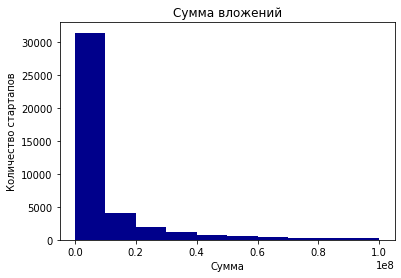

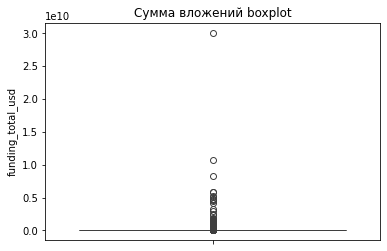

In [39]:
hist_box(data=train_0, column='funding_total_usd', bins=10, range=(0, 1e8), title='Сумма вложений', xlabel='Сумма',
         ylabel='Количество стартапов', cycle=None)

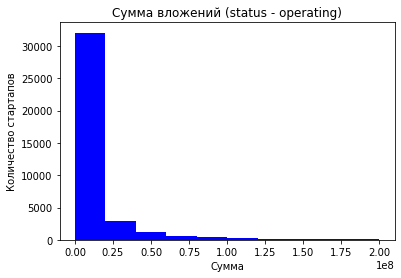

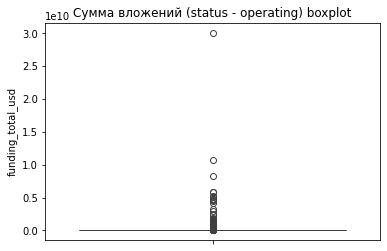

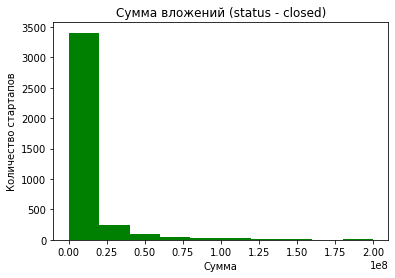

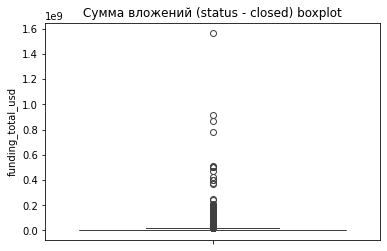

In [40]:
hist_box(data=train_0, column='funding_total_usd', bins=10, range=(0, 2e8), title='Сумма вложений', xlabel='Сумма',
         ylabel='Количество стартапов', cycle='status')

**Суммы вложений по срезам целевого признака распределены примерно одинаково.**

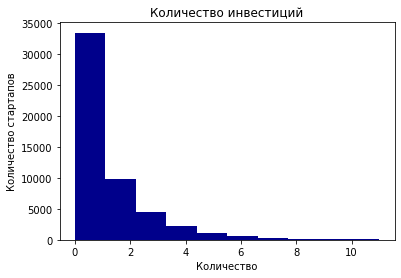

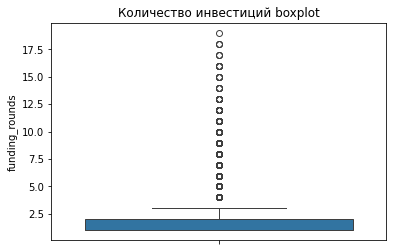

In [41]:
hist_box(data=train_0, column='funding_rounds', bins=10, range=(0, 11), title='Количество инвестиций', xlabel='Количество',
         ylabel='Количество стартапов', cycle=None)

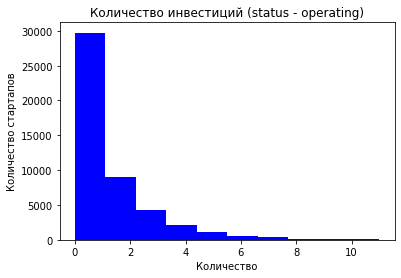

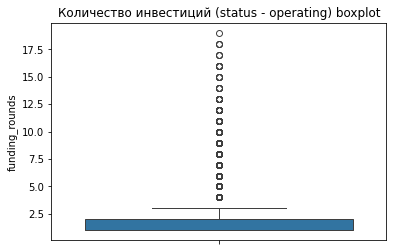

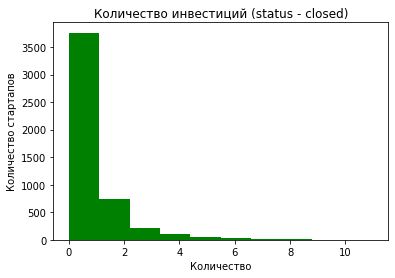

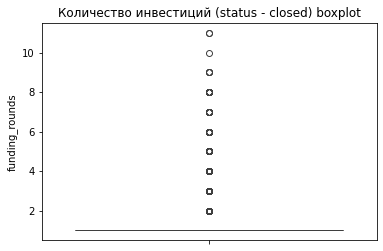

In [42]:
hist_box(data=train_0, column='funding_rounds', bins=10, range=(0, 11), title='Количество инвестиций', xlabel='Количество',
         ylabel='Количество стартапов', cycle='status')

**Количество инвестиций также распределено одинаково.**

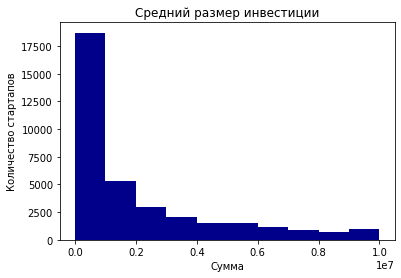

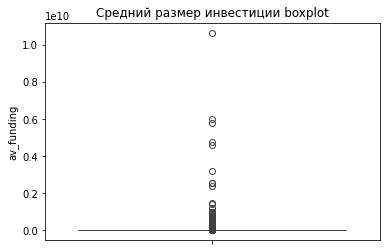

In [43]:
hist_box(data=train_0, column='av_funding', bins=10, range=(0, 1e7), title='Средний размер инвестиции', xlabel='Сумма',
         ylabel='Количество стартапов', cycle=None)

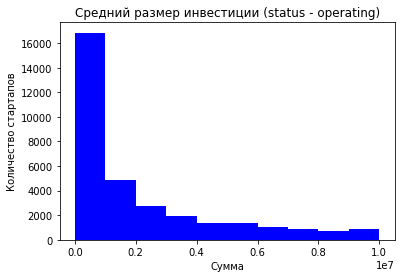

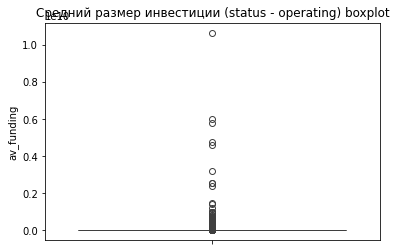

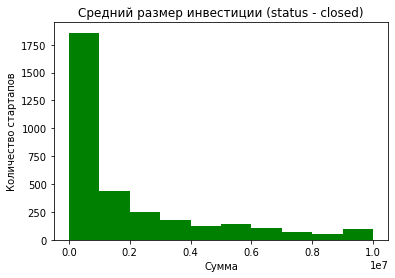

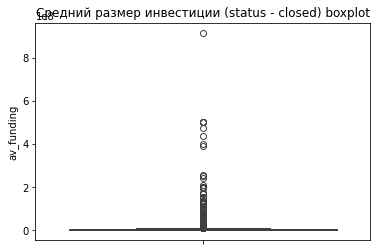

In [44]:
hist_box(data=train_0, column='av_funding', bins=10, range=(0, 1e7), title='Средний размер инвестиции', xlabel='Сумма',
         ylabel='Количество стартапов', cycle='status')

**Аналогично и для среднего размера инвестиции.**

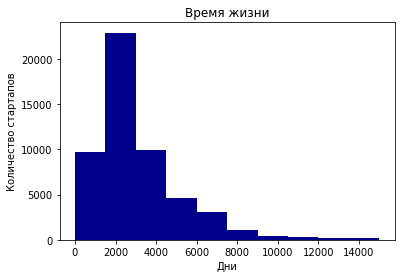

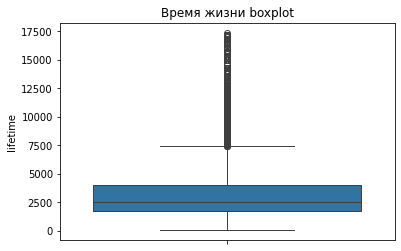

In [45]:
hist_box(data=train_0, column='lifetime', bins=10, range=(0, 1.5e4), title='Время жизни', xlabel='Дни',
         ylabel='Количество стартапов', cycle=None)

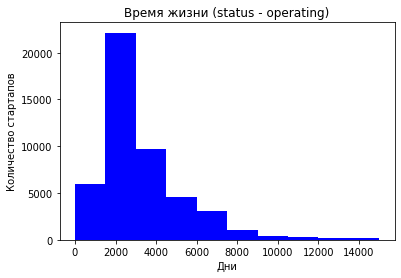

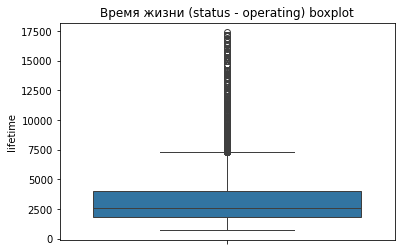

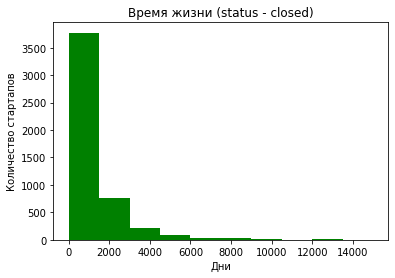

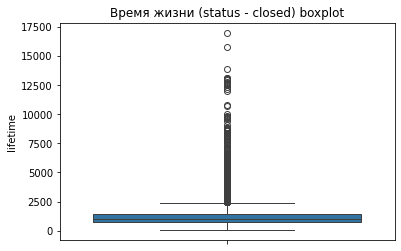

In [46]:
hist_box(data=train_0, column='lifetime', bins=10, range=(0, 1.5e4), title='Время жизни', xlabel='Дни',
         ylabel='Количество стартапов', cycle='status')

**Время жизни закрытых компаний в общем ниже, чем у действующих.**

**Напишу функцию для построения круговых диаграмм по срезам. И применю ее для анализа категориальных признаков.**

In [47]:
def circle(data, column, title=' ', cycle=None):
    '''Строит круговые диаграммы по генеральной выборке и по срезам.'''
    if cycle==None:
        tabl=data[column].value_counts().reset_index()
        tabl.columns=['a', 'b']
        plt.pie(tabl['b'], labels=tabl['a'], autopct='%1.1f%%', startangle=90)
        plt.title(label=title)
        plt.show()
    else:
        for i in data[cycle].unique():
            tabl=data[data[cycle]==i][column].value_counts().reset_index()
            tabl.columns=['a', 'b']
            plt.pie(tabl['b'], labels=tabl['a'], autopct='%1.1f%%', startangle=90)
            plt.title(label=title + '('+cycle+' - '+i+')')
            plt.show()

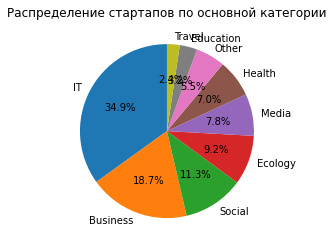

In [48]:
circle(train_0, 'category_0', title='Распределение стартапов по основной категории')

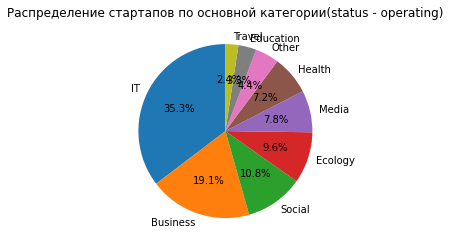

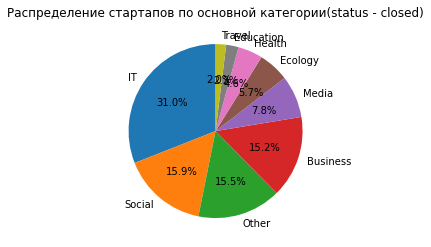

In [49]:
circle(train_0, 'category_0', title='Распределение стартапов по основной категории', cycle='status')

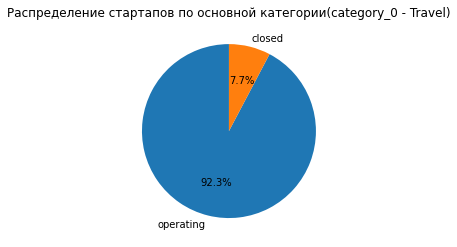

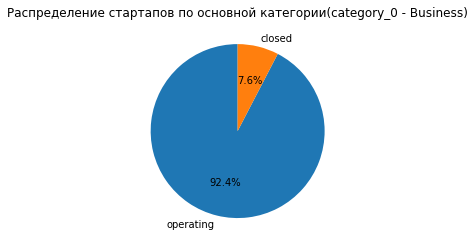

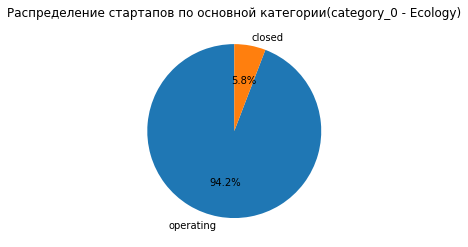

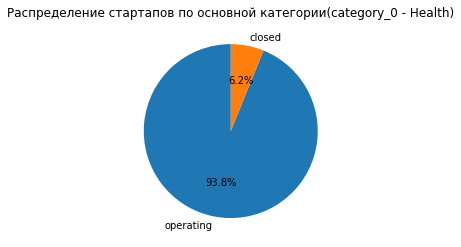

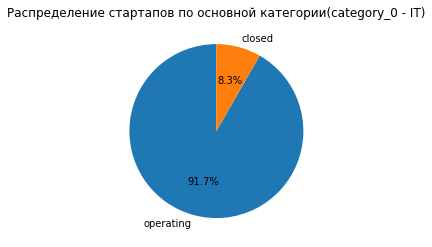

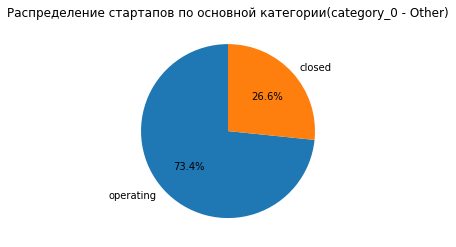

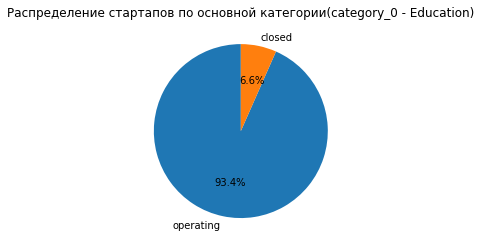

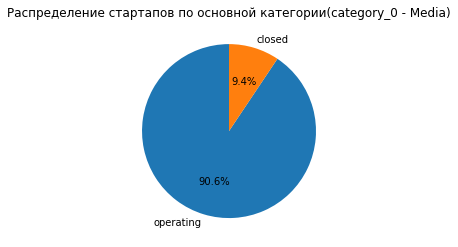

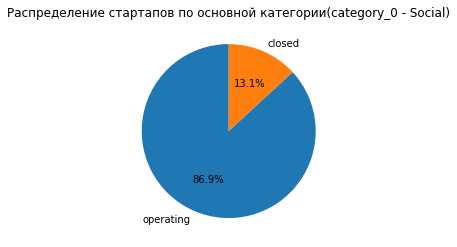

In [50]:
circle(train_0, 'status', title='Распределение стартапов по основной категории', cycle='category_0')

**Больше всего компаний, связанных с технологиями и бизнесом. Закрываются компании из всех категорий, но чаще всего из категории 'Другое'**

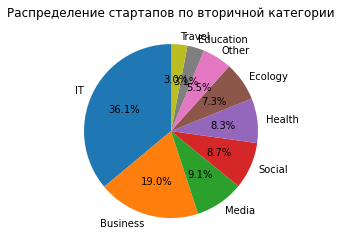

In [51]:
circle(train_0, 'category_1', title='Распределение стартапов по вторичной категории', cycle=None)

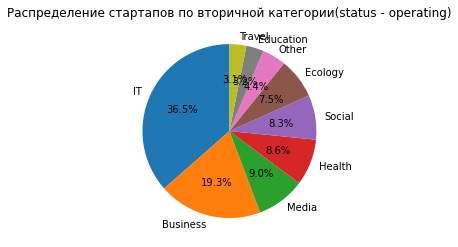

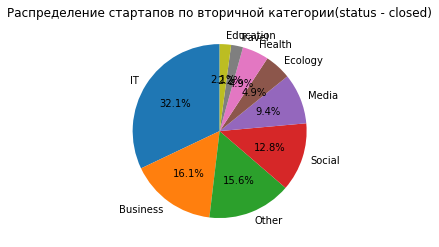

In [52]:
circle(train_0, 'category_1', title='Распределение стартапов по вторичной категории', cycle='status')

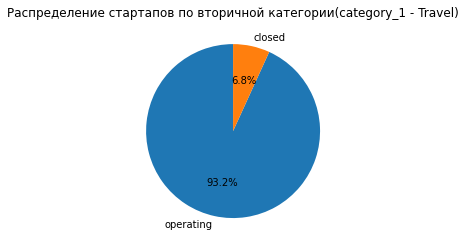

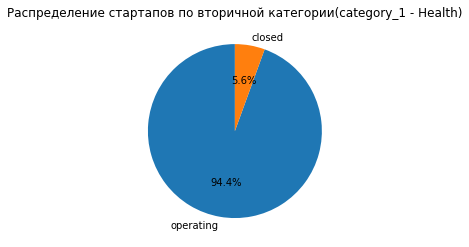

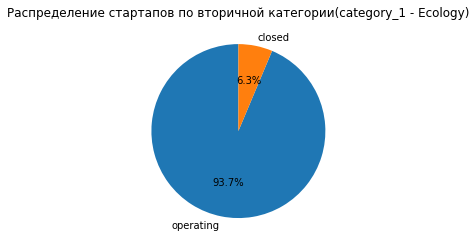

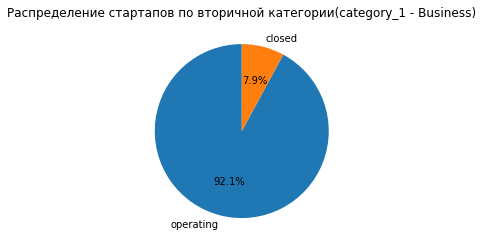

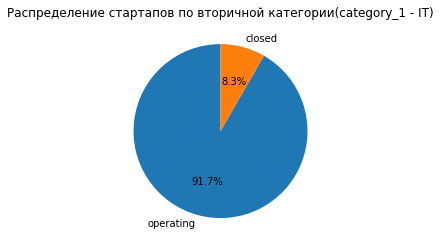

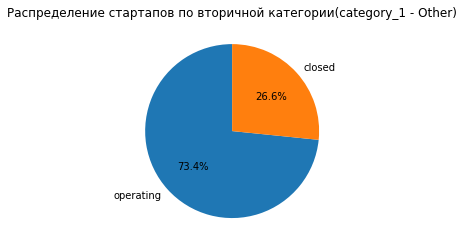

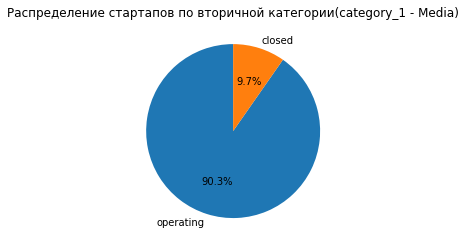

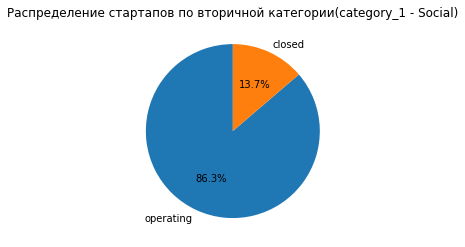

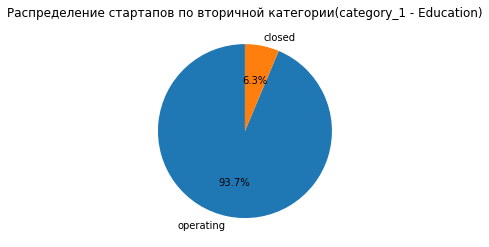

In [53]:
circle(train_0, 'status', title='Распределение стартапов по вторичной категории', cycle='category_1')

**Во вторичной категории такая же ситуация.**

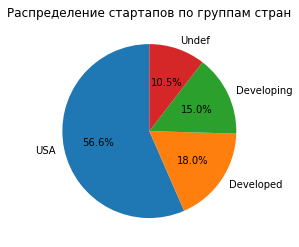

In [54]:
circle(train_0, 'country_group', title='Распределение стартапов по группам стран', cycle=None)

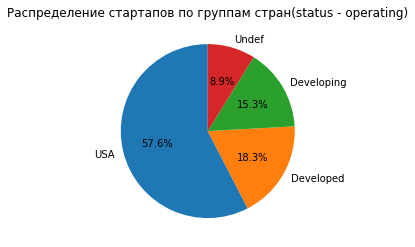

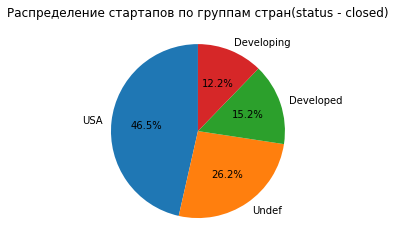

In [55]:
circle(train_0, 'country_group', title='Распределение стартапов по группам стран', cycle='status')

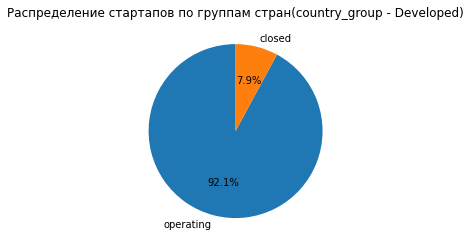

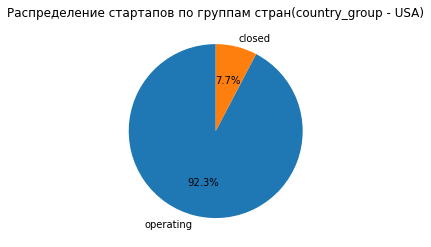

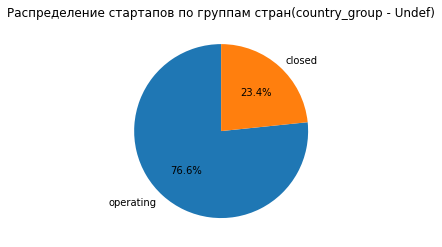

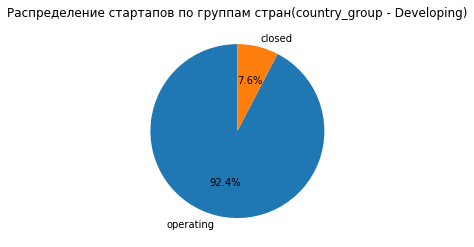

In [56]:
circle(train_0, 'status', title='Распределение стартапов по группам стран', cycle='country_group')

**Чаще всего закрываются компании, страны которых не обозначены в датасете.**

In [57]:
train_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                52516 non-null  object        
 1   category_list       52516 non-null  object        
 2   funding_total_usd   42447 non-null  float64       
 3   status              52516 non-null  object        
 4   country_code        52516 non-null  object        
 5   state_code          52516 non-null  object        
 6   region              52516 non-null  object        
 7   city                52516 non-null  object        
 8   funding_rounds      52516 non-null  int64         
 9   founded_at          52516 non-null  object        
 10  first_funding_at    52516 non-null  object        
 11  last_funding_at     52516 non-null  object        
 12  closed_at           4917 non-null   object        
 13  founded_at_d        52516 non-null  datetime64

**Переведу даты в числа (количество дней от 1970-01-01), чтобы проще было строить графики и корреляции.**

In [58]:
train_0['founded_at_f']=(train_0['founded_at_d']-datetime.strptime("1970-01-01", "%Y-%m-%d")).astype(str).\
apply(lambda x: x.replace(' days','')).astype(int)
train_0['first_funding_at_f']=(train_0['first_funding_at_d']-datetime.strptime("1970-01-01", "%Y-%m-%d")).astype(str).\
apply(lambda x: x.replace(' days','')).astype(int)
train_0['last_funding_at_f']=(train_0['last_funding_at_d']-datetime.strptime("1970-01-01", "%Y-%m-%d")).astype(str).\
apply(lambda x: x.replace(' days','')).astype(int)
train_0['closed_at_f']=(train_0['closed_at_d']-datetime.strptime("1970-01-01", "%Y-%m-%d")).astype(str).\
apply(lambda x: x.replace(' days','')).astype(int)
train_0['closed_at_d']=train_0['closed_at'].fillna('2018-01-01').apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
train_1=train_0[['name', 'funding_total_usd', 'country_code', 'funding_rounds', 'founded_at_f', 'first_funding_at_f',
                 'last_funding_at_f', 'closed_at_f', 'lifetime', 'category_0', 'category_1', 'country_group', 
                'bef_first', 'av_funding', 'status']].set_index('name')

**Я считаю, регион, штат и город большой роли не играют, а изучать их сложно в связи с тем, что в разных странах разные обозначения, поэтому я их уберу.**

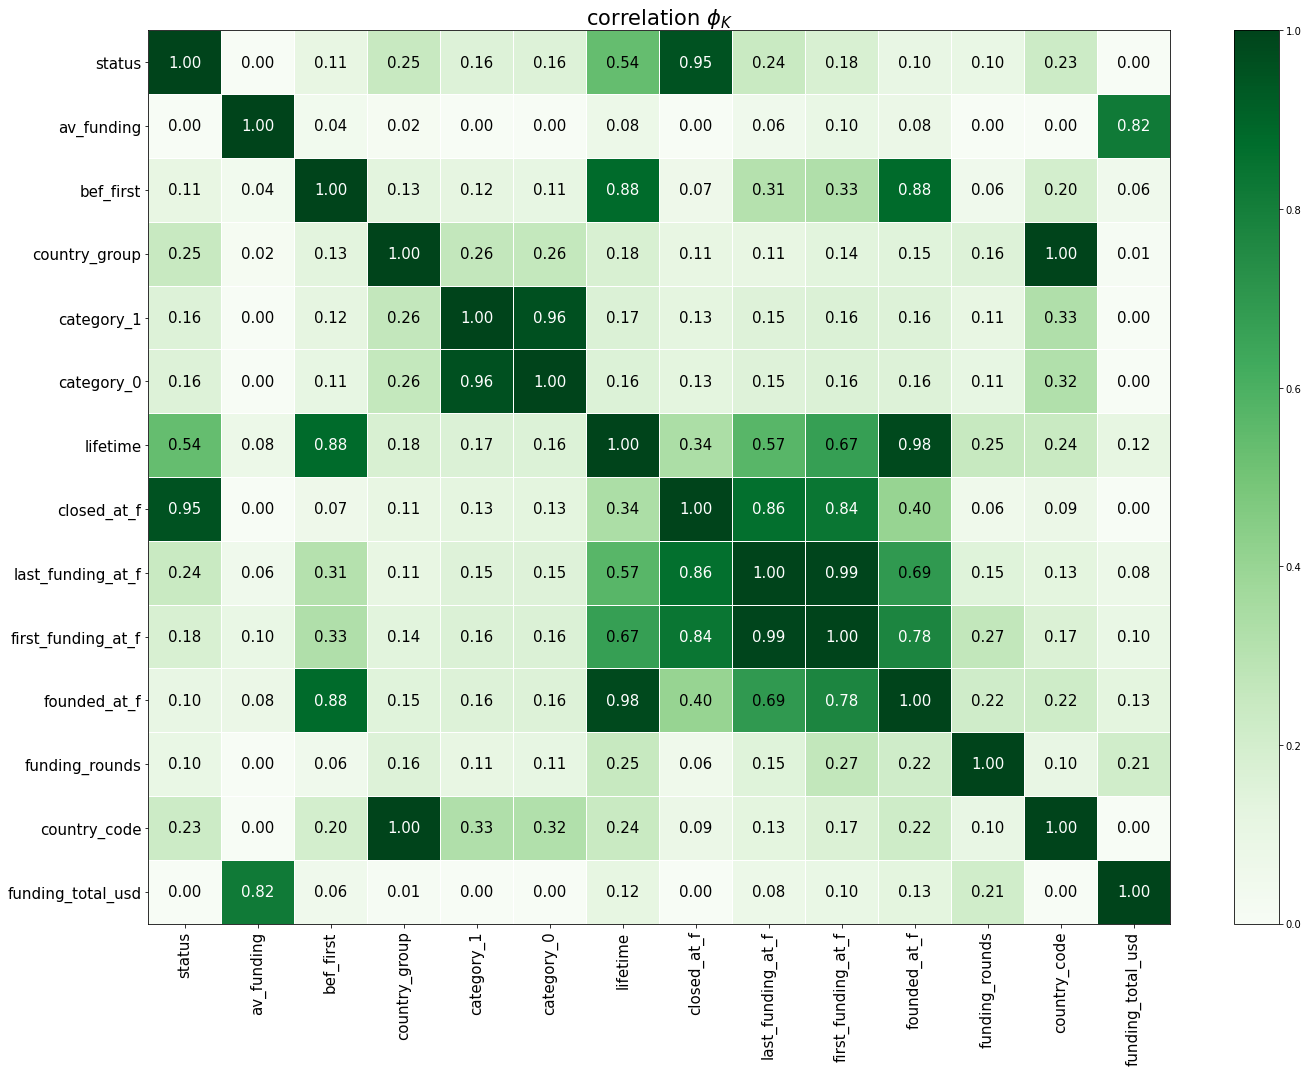

In [59]:
# создаём список с наименованиями количественных признаков
interval_cols = ['funding_total_usd', 'funding_rounds', 'av_funding', 'lifetime', 'bef_first', 'founded_at_f',
                 'first_funding_at_f', 'last_funding_at_f', 'closed_at_f']

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(train_1, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

**Наблюдается очевидная утечка целевого признака в признаке closed_at, поскольку они напрямую связаны. Также, между некоторыми признаками наблюдается мультиколлинеарность, изучу ее подробнее.**

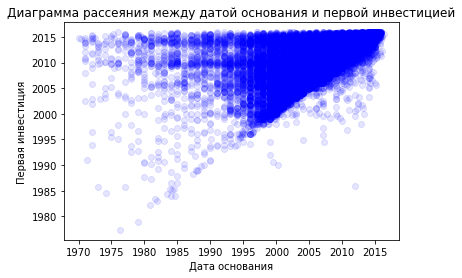

In [60]:
plt.scatter(train_0.founded_at_d, train_0.first_funding_at_d, color='blue', alpha=0.1)
plt.title('Диаграмма рассеяния между датой основания и первой инвестицией')
plt.xlabel('Дата основания')
plt.ylabel('Первая инвестиция')
plt.show()

**Разброс данных очень большой, будет очень трудно восстановить дату основания по дате первой инвестиции.**

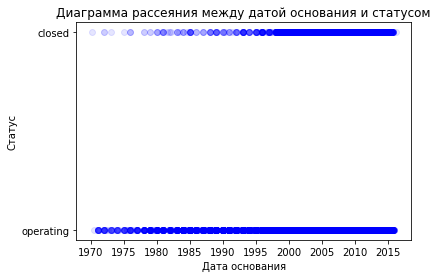

In [61]:
plt.scatter(train_0.founded_at_d, train_0.status, color='blue', alpha=0.1)
plt.title('Диаграмма рассеяния между датой основания и статусом')
plt.xlabel('Дата основания')
plt.ylabel('Статус')
plt.show()

**Дата основания почти не влияет на целевой признак.**

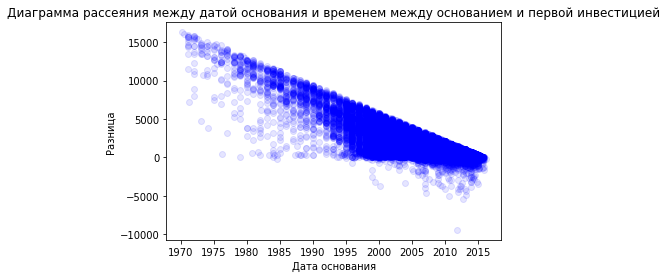

In [62]:
plt.scatter(train_0.founded_at_d, train_0.bef_first, color='blue', alpha=0.1)
plt.title('Диаграмма рассеяния между датой основания и временем между основанием и первой инвестицией')
plt.xlabel('Дата основания')
plt.ylabel('Разница')
plt.show()

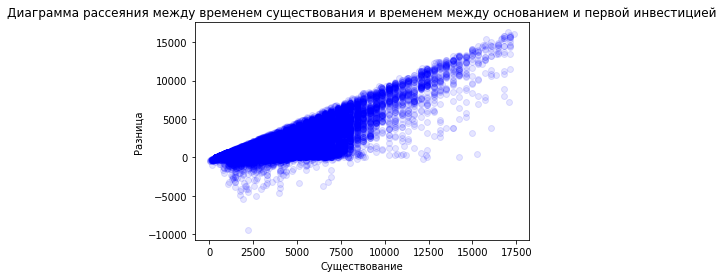

In [63]:
plt.scatter(train_0.lifetime, train_0.bef_first, color='blue', alpha=0.1)
plt.title('Диаграмма рассеяния между временем существования и временем между основанием и первой инвестицией')
plt.xlabel('Существование')
plt.ylabel('Разница')
plt.show()

**Корреляции прослеживаются, но разбросы слишком велики, чтобы пытаться восстановить даты основания.**

**Для инвестиций найду 'среднюю' дату инвестиций, поскольку оба признака важны, но они сильно коррелируют. Средняя сумма инвестиции не коррелирует со статусом, уберу ее из рассмотрения. Категории компаний сильно коррелируют между собой, поэтому оставлю только основную. Страна и ее группа также сильно коррелируют и влияют на целевой признак почти в равной степени, поэтому оставлю только группы. Сформирую окончательную таблицу.**

In [64]:
train_1['av_funding_at_f']=(train_1['last_funding_at_f']+train_1['first_funding_at_f'])/2
train_2=train_1[['funding_total_usd', 'funding_rounds', 'av_funding_at_f', 'lifetime', 'category_0', 'country_group', 'status']]

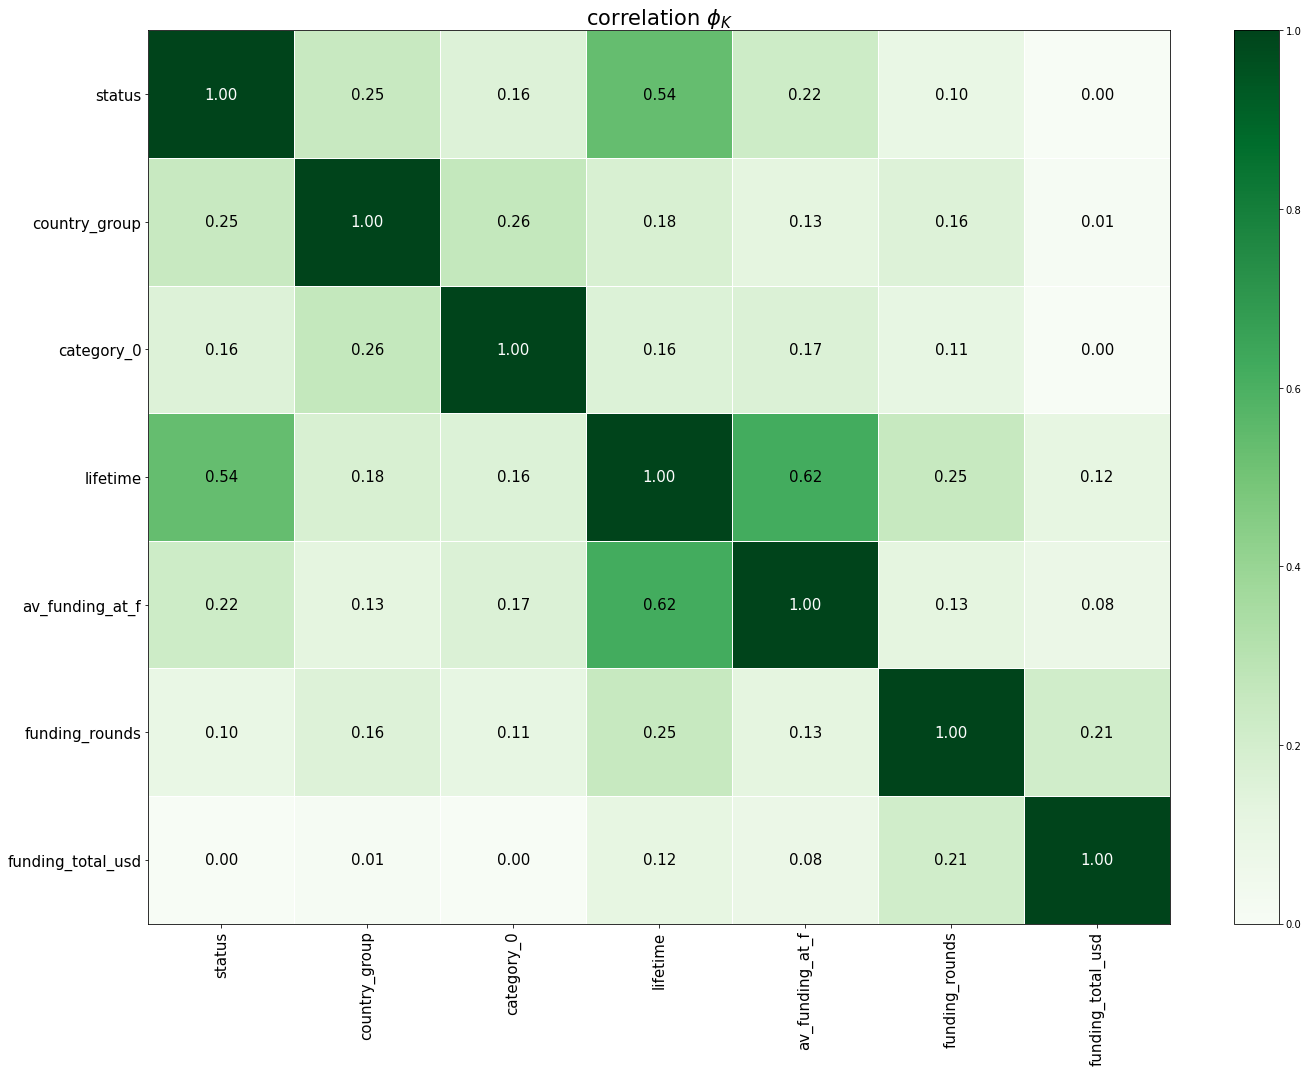

In [65]:
# создаём список с наименованиями количественных признаков
interval_cols = ['funding_total_usd', 'funding_rounds', 'lifetime', 'av_funding_at_f']

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(train_2, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

In [66]:
train_2.head(15)

,funding_total_usd,funding_rounds,av_funding_at_f,lifetime,category_0,country_group,status
name,,,,,,,
Lunchgate,828626.0,2,15750.0,2998,Travel,Developed,operating
EarLens,42935019.0,4,15429.5,4748,Business,USA,operating
Reviva Pharmaceuticals,35456381.0,3,15912.5,4383,Ecology,USA,operating
Sancilio and Company,22250000.0,3,15743.5,5114,Health,Undef,operating
WireTough Cylinders,NaN,1,15371.0,2791,Business,USA,operating
Connected Sports Ventures,4300000.0,1,15656.0,2452,IT,USA,operating
Attensity,90000000.0,1,16204.0,6575,IT,USA,operating
Mesh Networks,4300000.0,1,16383.0,4748,IT,USA,operating
AngioScore,42000000.0,2,14439.5,5479,Ecology,USA,operating


In [67]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, Lunchgate to Apparcando
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   funding_total_usd  42447 non-null  float64
 1   funding_rounds     52516 non-null  int64  
 2   av_funding_at_f    52516 non-null  float64
 3   lifetime           52516 non-null  int32  
 4   category_0         52516 non-null  object 
 5   country_group      52516 non-null  object 
 6   status             52516 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(3)
memory usage: 3.0+ MB


**Теперь всё хорошо, останется только заполнить пропуски в общей сумме инвестиций.**

**Проведу те же преобразования с тестовой выборкой, чтобы синхронизировать нецелевые признаки.**

In [68]:
test_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [69]:
test_0['category_list']=test_0['category_list'].fillna('Undef')
test_0['category_0']=test_0['category_list'].apply(lambda x: category(spl_0(x)))
test_0['country_group']=test_0['country_code'].apply(coun_gr)
test_0['av_funding_at_f']=(((test_0['first_funding_at'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))-\
                            datetime.strptime("1970-01-01", "%Y-%m-%d")).astype(str).\
                            apply(lambda x: x.replace(' days','')).astype(int))+\
                            ((test_0['last_funding_at'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))-\
                            datetime.strptime("1970-01-01", "%Y-%m-%d")).astype(str).\
                            apply(lambda x: x.replace(' days','')).astype(int)))/2
test_2=test_0[['name', 'funding_total_usd', 'funding_rounds', 'av_funding_at_f', 'lifetime', 'category_0',
               'country_group']].set_index('name')
test_2.head(15)

,funding_total_usd,funding_rounds,av_funding_at_f,lifetime,category_0,country_group
name,,,,,,
Crystalsol,2.819200e+06,1,14426.0,3501,IT,Developing
JBI Fish & Wings,NaN,1,14818.0,2717,Travel,USA
COINPLUS,4.282570e+05,2,16268.0,1295,Business,Developed
Imagine Communications,3.470000e+07,4,13751.5,4748,IT,USA
DNA13,4.530000e+06,1,13641.0,6209,IT,Developed
Quickfire Games,1.600000e+05,2,16148.5,1583,Social,Developing
Sente Inc.,2.684200e+07,5,15249.0,4018,Ecology,USA
Triosyn,4.000000e+06,1,12205.0,5576,Health,Developing
Urgent.ly,8.710000e+06,3,16442.0,1826,IT,USA


In [70]:
test_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   funding_total_usd  10547 non-null  float64
 1   funding_rounds     13125 non-null  int64  
 2   av_funding_at_f    13125 non-null  float64
 3   lifetime           13125 non-null  int64  
 4   category_0         13125 non-null  object 
 5   country_group      13125 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 717.8+ KB


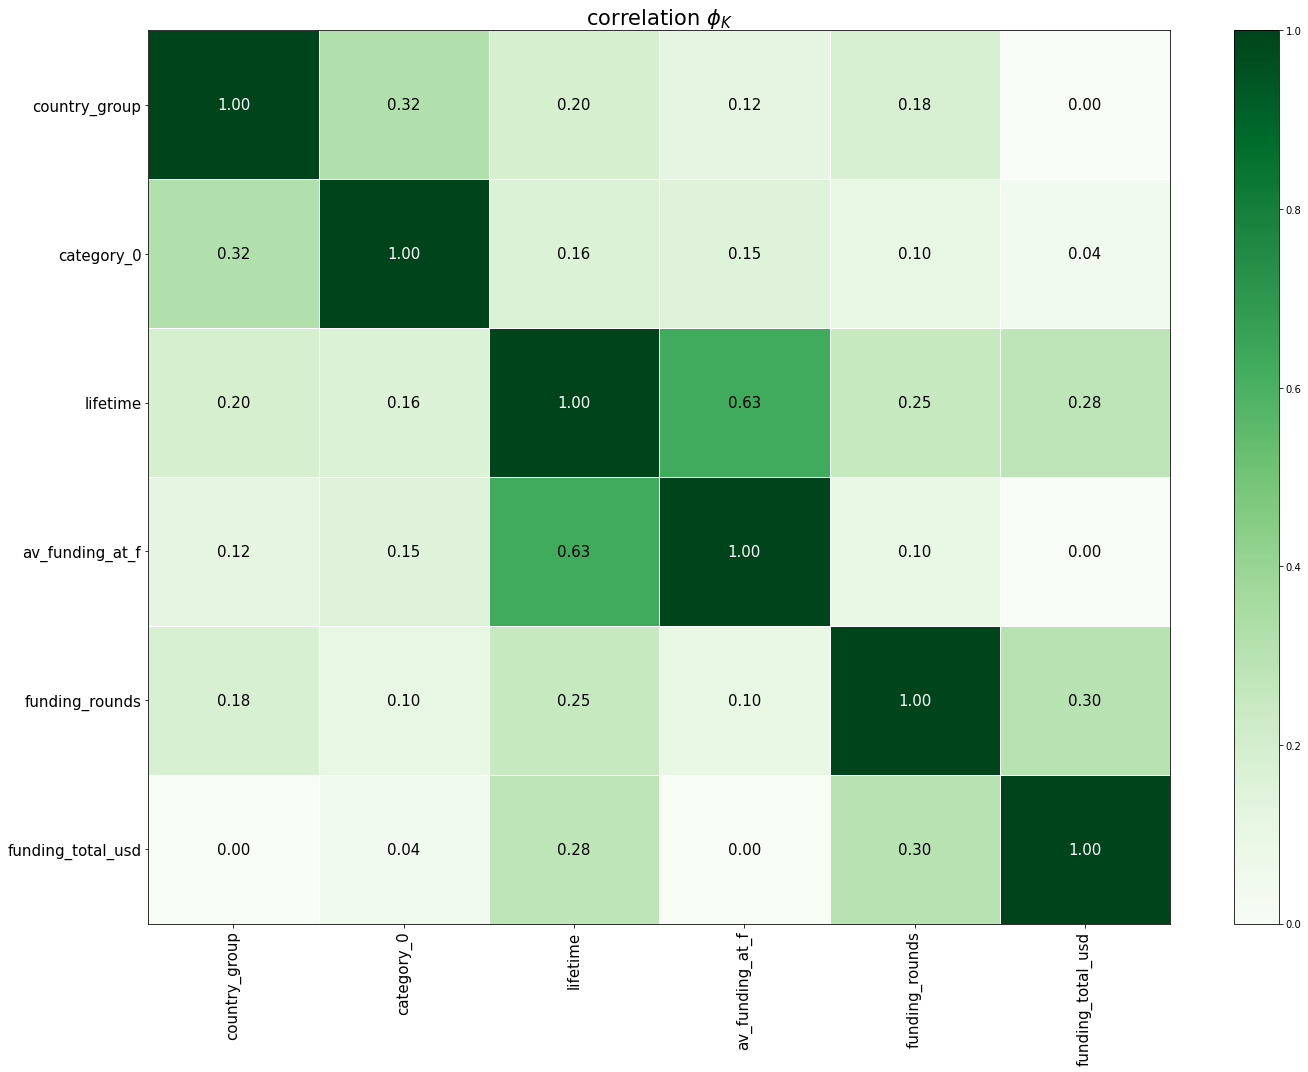

In [71]:
# создаём список с наименованиями количественных признаков
interval_cols = ['funding_total_usd', 'funding_rounds', 'lifetime', 'av_funding_at_f']

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(test_2, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

**Мультиколлинеарности не наблюдается. Проведу исследовательский анализ тестового датасета.** 

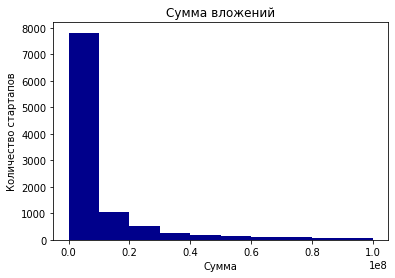

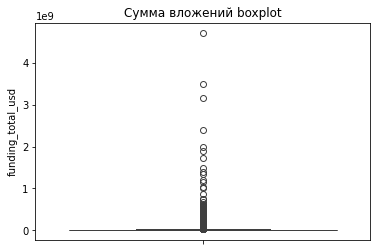

In [72]:
hist_box(data=test_2, column='funding_total_usd', bins=10, range=(0, 1e8), title='Сумма вложений', xlabel='Сумма',
         ylabel='Количество стартапов', cycle=None)

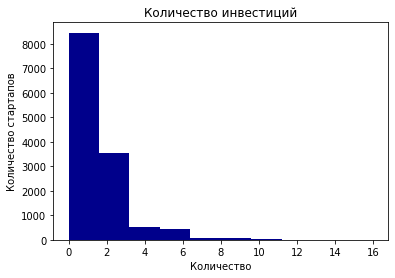

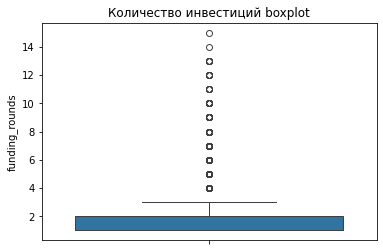

In [73]:
hist_box(data=test_2, column='funding_rounds', bins=10, range=(0, 16), title='Количество инвестиций', xlabel='Количество',
         ylabel='Количество стартапов', cycle=None)

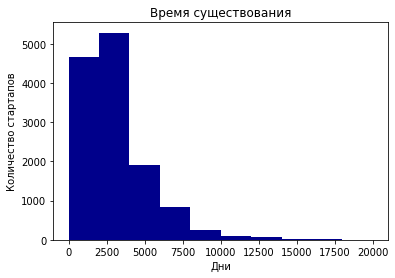

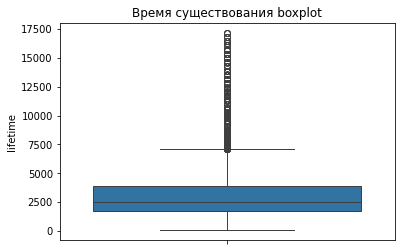

In [74]:
hist_box(data=test_2, column='lifetime', bins=10, range=(0, 20000), title='Время существования', xlabel='Дни',
         ylabel='Количество стартапов', cycle=None)

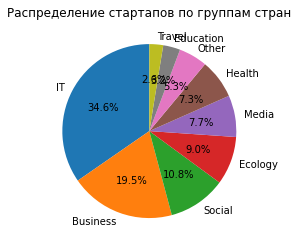

In [75]:
circle(test_2, 'category_0', title='Распределение стартапов по группам стран', cycle=None)

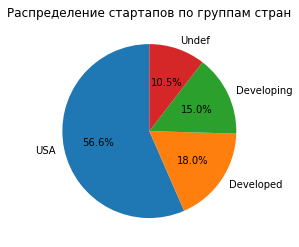

In [76]:
circle(train_0, 'country_group', title='Распределение стартапов по группам стран', cycle=None)

**Все распределения очень близки к соответствующим распределениям в тренировочной выборке.**

**Заполню пропуски в общей сумме медианным значением для тех стартапов, в которых вкладывались 1 раз (среди строк с пропусками таких - подавляющее большинство).**

In [77]:
med_train=train_2[train_2['funding_rounds']==1]['funding_total_usd'].median()
med_test=test_2[test_2['funding_rounds']==1]['funding_total_usd'].median()
train_2['funding_total_usd']=train_2['funding_total_usd'].fillna(med_train)
test_2['funding_total_usd']=test_2['funding_total_usd'].fillna(med_test)

C:\Users\User\AppData\Local\Temp/ipykernel_3156/1950779800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2['funding_total_usd']=train_2['funding_total_usd'].fillna(med_train)


In [78]:
train_2.info()
test_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, Lunchgate to Apparcando
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   funding_total_usd  52516 non-null  float64
 1   funding_rounds     52516 non-null  int64  
 2   av_funding_at_f    52516 non-null  float64
 3   lifetime           52516 non-null  int32  
 4   category_0         52516 non-null  object 
 5   country_group      52516 non-null  object 
 6   status             52516 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(3)
memory usage: 3.0+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   funding_total_usd  13125 non-null  float64
 1   funding_rounds     13125 non-null  int64  
 2   av_funding_at_f    13125 non-null  float64
 3   lifetime         

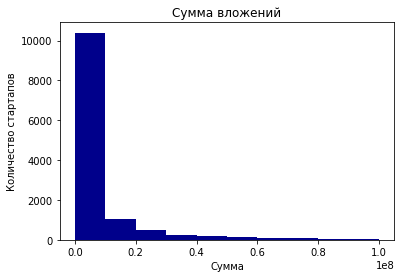

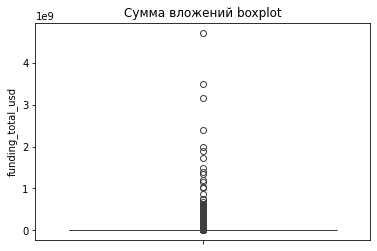

In [79]:
hist_box(data=test_2, column='funding_total_usd', bins=10, range=(0, 1e8), title='Сумма вложений', xlabel='Сумма',
         ylabel='Количество стартапов', cycle=None)

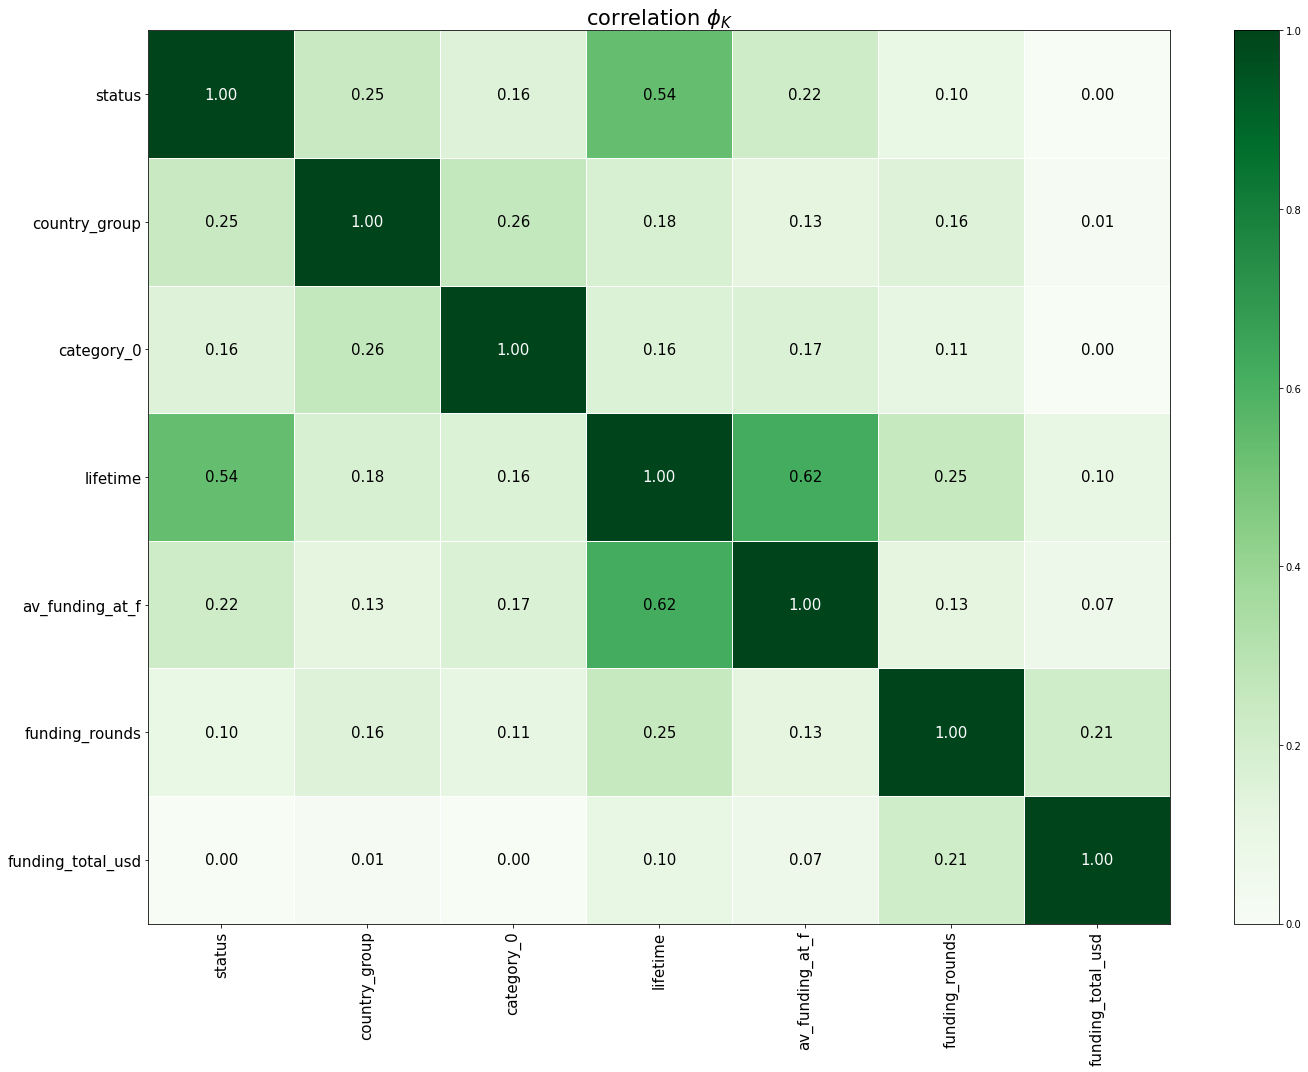

In [80]:
phik_overview = phik_matrix(train_2, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

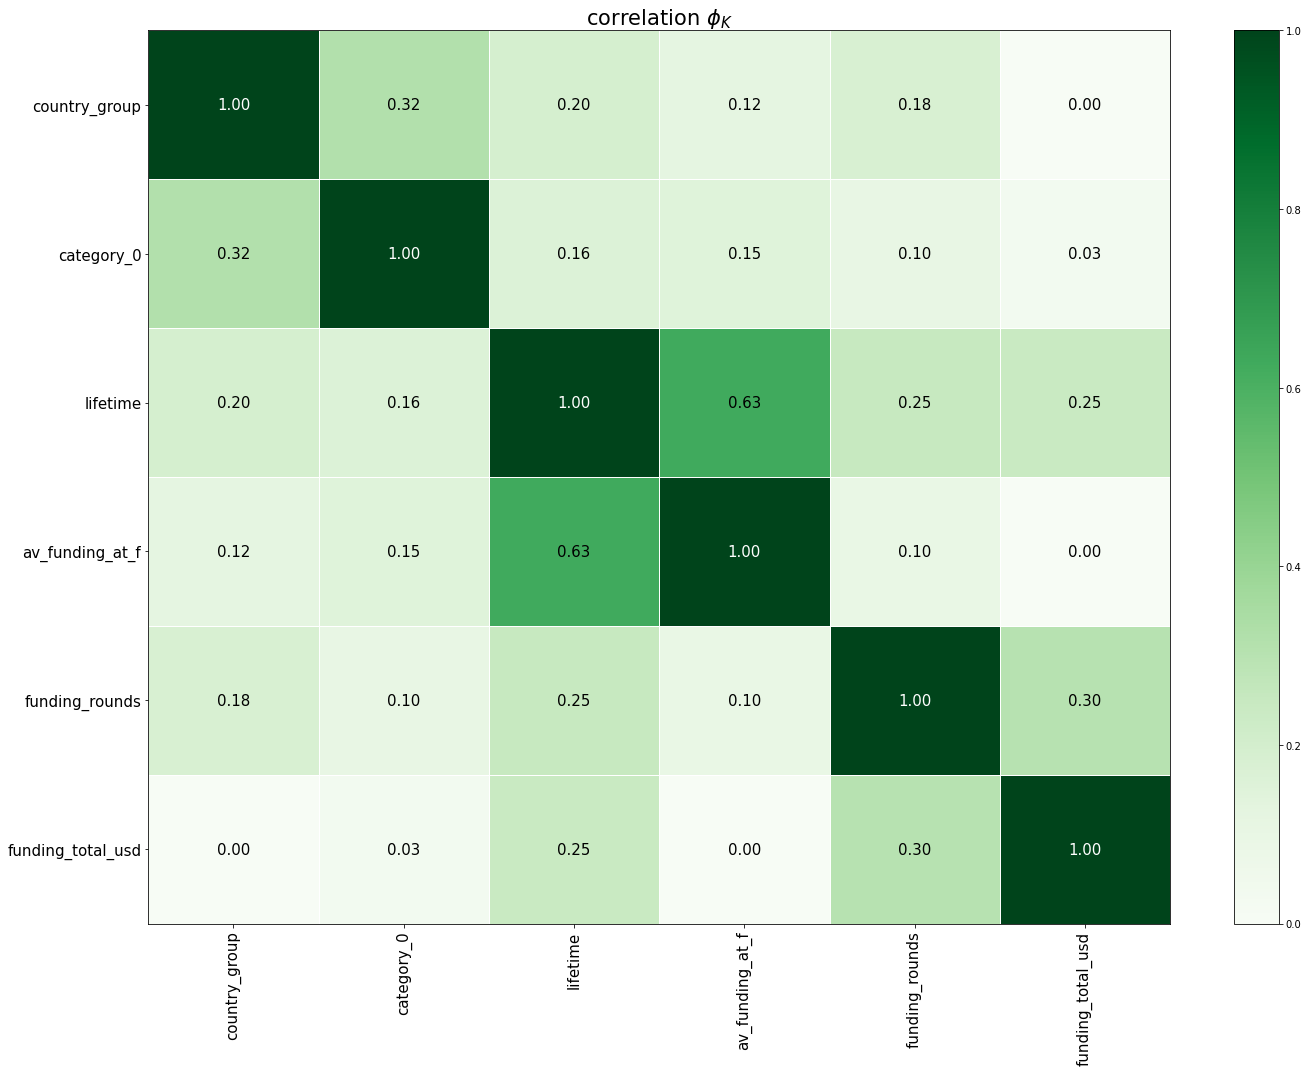

In [81]:
phik_overview = phik_matrix(test_2, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

**На общий вид распределения и матрицу корреляции это не повлияло, поэтому заполнение оправдано.**

## Обучение и проверка модели <a class="anchor" id="chapter4"></a>

**Проведу оверсемплинг при помощи ADASYN. Он синтезирует новые данные, не копируя их. А также в отличие от SMOTE упростит категоризацию. Предварительно проведу кодирование категориальных признаков.**

In [82]:
#Разбиваю признаки на целевой и нецелевые
X_0=train_2.drop(['status'], axis=1)
y_0=train_2.status.apply(lambda x: 1 if x=='closed' else 0)

#Кодирую категориальные признаки
cols_ohe = ['category_0', 'country_group']
oh_encoder = OneHotEncoder(drop='first', sparse_output=False)
oh_encoder.fit(X_0[cols_ohe])
encoder_col_names = oh_encoder.get_feature_names_out()

X_0[encoder_col_names] = oh_encoder.transform(X_0[cols_ohe])

X_0=X_0.drop(['category_0', 'country_group'], axis=1)

#Провожу оверсемплинг
sampler=ADASYN(random_state=RANDOM_STATE)
X, y=sampler.fit_resample(X_0, y_0)

In [83]:
X.head(15)

,funding_total_usd,funding_rounds,av_funding_at_f,lifetime,category_0_Ecology,category_0_Education,category_0_Health,category_0_IT,category_0_Media,category_0_Other,category_0_Social,category_0_Travel,country_group_Developing,country_group_USA,country_group_Undef
0,828626.0,2,15750.0,2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,42935019.0,4,15429.5,4748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,35456381.0,3,15912.5,4383,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,22250000.0,3,15743.5,5114,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,860000.0,1,15371.0,2791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,4300000.0,1,15656.0,2452,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,90000000.0,1,16204.0,6575,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,4300000.0,1,16383.0,4748,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,42000000.0,2,14439.5,5479,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1250500.0,2,15497.0,2922,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [84]:
y.head(15)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    1
13    0
14    0
Name: status, dtype: int64

In [85]:
X.info()
y.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95272 entries, 0 to 95271
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   funding_total_usd         95272 non-null  float64
 1   funding_rounds            95272 non-null  int64  
 2   av_funding_at_f           95272 non-null  float64
 3   lifetime                  95272 non-null  int32  
 4   category_0_Ecology        95272 non-null  float64
 5   category_0_Education      95272 non-null  float64
 6   category_0_Health         95272 non-null  float64
 7   category_0_IT             95272 non-null  float64
 8   category_0_Media          95272 non-null  float64
 9   category_0_Other          95272 non-null  float64
 10  category_0_Social         95272 non-null  float64
 11  category_0_Travel         95272 non-null  float64
 12  country_group_Developing  95272 non-null  float64
 13  country_group_USA         95272 non-null  float64
 14  countr

1    47673
0    47599
Name: status, dtype: int64

**Данных стало значительно больше и распределение классов в целевом признаке сейчас 1:1.**

In [86]:
num_columns = X.columns.to_list()

In [87]:
#Разбиваю выборку на тренировочную и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size = 0.25, 
    random_state = RANDOM_STATE)

#Провожу масштабирование всех количественных признаков (старых и новых после кодирования)
data_preprocessor = ColumnTransformer(
    [('num', StandardScaler(), num_columns)], 
    remainder='passthrough'
)

#Создаю итоговый пайплайн, содержащий подготовку данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])

#В param_grid переберу 4 модели и признаки для них
#Для масштабирования использую 2 разных скейлера и вариант без масштабирования
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3,20),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(2,5),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__C': range(2,5),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']         
    }
    
]

#Параметров и данных много, поэтому буду использовать рандомизированный поиск по сетке
#В качестве метрики устанавливаю f1, по условиям задания

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика f1 лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['funding_total_usd',
                                                   'funding_rounds',
                                                   'av_funding_at_f',
                                                   'lifetime',
                                                   'category_0_Ecology',
                                                   'category_0_Education',
                                                   'category_0_Health',
                                                   'category_0_IT',
                                                   'category_0_Media',
                                                   'category_0_Other',
                                                   'category_0_Social',
                        

**Лучшая модель - KNeighborsClassifier(), лучший скейлер - StandardScaler(). У меня поиск идет примерно 3-4 минуты. Метрика f1 лучшей модели на тренировочной выборке: 0.9561000879450393.**

In [88]:
y_test_pred = randomized_search.predict(X_valid)
print(f'Метрика f1 на валидационной выборке: {f1_score(y_valid, y_test_pred)}')

Метрика f1 на валидационной выборке: 0.9600205461861142


**Метрика f1 на валидационной выборке: 0.9600205461861142.**

## Проверка важности признаков <a class="anchor" id="chapter5"></a>

**У меня эта проверка даже на таких маленьких выборках шла примерно 25 минут, поэтому я закомментровал этот участок кода. При необходимости можно раскомментировать.**

In [89]:
'''
prep = ColumnTransformer(
    [('num', StandardScaler(), num_columns)], 
    remainder='passthrough'
)
X_train_scaled=prep.fit_transform(X_train)
X_valid_scaled=prep.transform(X_valid)
feature_names = prep.get_feature_names_out()

knn=KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

X_sample_test = shap.sample(X_valid_scaled,15)
X_sample_train = shap.sample(X_train_scaled,45)
explainer = shap.KernelExplainer(knn.predict_proba, X_sample_train)
shap_values = explainer(X_sample_test)
shap_values.feature_names=feature_names

shap.plots.bar(shap_values[:,:,1], max_display=16)
plt.show()
shap.plots.beeswarm(shap_values[:,:,1], max_display=16)
plt.show()
'''

"\nprep = ColumnTransformer(\n    [('num', StandardScaler(), num_columns)], \n    remainder='passthrough'\n)\nX_train_scaled=prep.fit_transform(X_train)\nX_valid_scaled=prep.transform(X_valid)\nfeature_names = prep.get_feature_names_out()\n\nknn=KNeighborsClassifier()\nknn.fit(X_train_scaled, y_train)\n\nX_sample_test = shap.sample(X_valid_scaled,15)\nX_sample_train = shap.sample(X_train_scaled,45)\nexplainer = shap.KernelExplainer(knn.predict_proba, X_sample_train)\nshap_values = explainer(X_sample_test)\nshap_values.feature_names=feature_names\n\nshap.plots.bar(shap_values[:,:,1], max_display=16)\nplt.show()\nshap.plots.beeswarm(shap_values[:,:,1], max_display=16)\nplt.show()\n"

**Самыми важными, как и ожидалось (из матрицы корреляции), оказались признаки lifetime и 'средняя дата инвестиций'.**

**Теперь проведу предсказание по тестовой выборке, предварительно ее подготовив с использованием уже обученных кодера, скейлера и предсказательной модели.**

In [90]:
X_valid.head()

,funding_total_usd,funding_rounds,av_funding_at_f,lifetime,category_0_Ecology,category_0_Education,category_0_Health,category_0_IT,category_0_Media,category_0_Other,category_0_Social,category_0_Travel,country_group_Developing,country_group_USA,country_group_Undef
19526,4.700000e+06,1,15498.00000,5114,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
19108,1.000000e+05,1,16728.00000,1096,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000
35458,8.600000e+05,1,16287.00000,3287,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000
47086,8.600000e+05,1,16269.00000,1826,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.000000
64638,4.007818e+04,1,16454.20366,744,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.546707,0.0,0.453293


In [91]:
test_2.head()

,funding_total_usd,funding_rounds,av_funding_at_f,lifetime,category_0,country_group
name,,,,,,
Crystalsol,2.819200e+06,1,14426.0,3501,IT,Developing
JBI Fish & Wings,8.841858e+05,1,14818.0,2717,Travel,USA
COINPLUS,4.282570e+05,2,16268.0,1295,Business,Developed
Imagine Communications,3.470000e+07,4,13751.5,4748,IT,USA
DNA13,4.530000e+06,1,13641.0,6209,IT,Developed


In [92]:
test_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   funding_total_usd  13125 non-null  float64
 1   funding_rounds     13125 non-null  int64  
 2   av_funding_at_f    13125 non-null  float64
 3   lifetime           13125 non-null  int64  
 4   category_0         13125 non-null  object 
 5   country_group      13125 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 717.8+ KB


In [93]:
test_2[encoder_col_names] = oh_encoder.transform(test_2[cols_ohe])

X_test=test_2.drop(['category_0', 'country_group'], axis=1)

X_test.head()

,funding_total_usd,funding_rounds,av_funding_at_f,lifetime,category_0_Ecology,category_0_Education,category_0_Health,category_0_IT,category_0_Media,category_0_Other,category_0_Social,category_0_Travel,country_group_Developing,country_group_USA,country_group_Undef
name,,,,,,,,,,,,,,,
Crystalsol,2.819200e+06,1,14426.0,3501,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
JBI Fish & Wings,8.841858e+05,1,14818.0,2717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
COINPLUS,4.282570e+05,2,16268.0,1295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Imagine Communications,3.470000e+07,4,13751.5,4748,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
DNA13,4.530000e+06,1,13641.0,6209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23818 entries, 19526 to 54636
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   funding_total_usd         23818 non-null  float64
 1   funding_rounds            23818 non-null  int64  
 2   av_funding_at_f           23818 non-null  float64
 3   lifetime                  23818 non-null  int32  
 4   category_0_Ecology        23818 non-null  float64
 5   category_0_Education      23818 non-null  float64
 6   category_0_Health         23818 non-null  float64
 7   category_0_IT             23818 non-null  float64
 8   category_0_Media          23818 non-null  float64
 9   category_0_Other          23818 non-null  float64
 10  category_0_Social         23818 non-null  float64
 11  category_0_Travel         23818 non-null  float64
 12  country_group_Developing  23818 non-null  float64
 13  country_group_USA         23818 non-null  float64
 14  co

In [95]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   funding_total_usd         13125 non-null  float64
 1   funding_rounds            13125 non-null  int64  
 2   av_funding_at_f           13125 non-null  float64
 3   lifetime                  13125 non-null  int64  
 4   category_0_Ecology        13125 non-null  float64
 5   category_0_Education      13125 non-null  float64
 6   category_0_Health         13125 non-null  float64
 7   category_0_IT             13125 non-null  float64
 8   category_0_Media          13125 non-null  float64
 9   category_0_Other          13125 non-null  float64
 10  category_0_Social         13125 non-null  float64
 11  category_0_Travel         13125 non-null  float64
 12  country_group_Developing  13125 non-null  float64
 13  country_group_USA         13125 non-null  float64
 

In [96]:
y_test_final_1 = randomized_search.predict(X_test)

In [97]:
pd.DataFrame(y_test_final_1).head(40)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


**Оформлю таблицу по образцу, необходимому для отправки.**

In [98]:
X_test_1=X_test.reset_index()
df=pd.DataFrame(y_test_final_1)
df.columns=['status_i']
X_test_1['status_i']=df.status_i
X_test_1['status']=X_test_1['status_i'].apply(lambda x: 'closed' if x==1 else 'operating')
prediction=X_test_1[['name', 'status']].set_index('name')
prediction.head(40)

,status
name,
Crystalsol,operating
JBI Fish & Wings,operating
COINPLUS,operating
Imagine Communications,operating
DNA13,operating
Quickfire Games,operating
Sente Inc.,operating
Triosyn,operating
Urgent.ly,operating


**Сформирую итоговый CSV-файл с предсказанием.**

In [99]:
prediction.to_csv('dozm_pred.csv', index=True)

In [100]:
prediction.value_counts()

status   
operating    12004
closed        1121
dtype: int64

**Метрика f1 на тестовой выборке равна 0.80337 (по подсчетам платформы Kaggle).**

## Общий вывод <a class="anchor" id="chapter6"></a>

**Работа была связана с изучением данных о стартапах, основанных и действующих в период с 1970 по 2018 гг. Данные были использованы для обучения различных моделей с целью прогнозирования закрытия компаний.   
В ходе работы:**
- Были открыты и рассмотрены предоставленные датасеты.
- Проведена предобработка данных, устранены пропуски, синтезированы новые признаки, преобразованы форматы данных.
- Построены и изучены диаграммы для всех данных. Аномалий замеченно не было.
- Проведен корреляционный анализ данных. Исследованы взаимосвязи между признаками. Устранены лишние признаки с мультколлинеарностью. Тестовая и тренировочная таблицы приведены к одинаковому виду.
- С помощью пайплайна обучены 4 модели. C помощь метрики f1 выбрана лучшая модель - KNeighboursClassifier. 
- Данная модель была применена для прогнозирования закрытия компаний. 
- Был проведен анализ важности признаков для предсказаний. Самыми влиятельными оказались время существования и дата инвестиций.
- Было проведено предсказание на тестовой выборке. Метрика f1 при этом составила 0.80337.
 **Конкретных рекомендаций стартапам я дать не могу, поскольку самыми важными оказались признаки, по большому счету не зависящие от основателей стартапов. Выгоднее всего начинать стартап в сферах IT и бизнеса, в этих категориях меньшая доля закрытых компаний.**